# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm 
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge, Lasso
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from scipy import stats
from sklearn.model_selection import GridSearchCV
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler,PowerTransformer, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import kendalltau, f_oneway
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer


# Functions

In [2]:
''' We got many null values from scraping so this function will convert null value to Nan values '''

def convert_to_nans(data):
    for i in range(len(data.columns)):
        data.loc[data.iloc[:, i] == "Null", data.columns[i]] = np.nan

In [3]:
def drop_outliers_for_categorical(df):
    IQR = 0
    
    q1 = df["prices"].quantile(.01)
    q3 = df["prices"].quantile(.99)
    
    IQR= q3 - q1
    
    lower= q1 - 1.5 * IQR
    upper= q3 + 1.5 * IQR

    
    data_without_outliers = df.drop(df[((df["prices"] > upper) | (df["prices"] < lower))].index, axis=0)
    data_without_outliers.reset_index(drop=True, inplace= True)
    
    return data_without_outliers


In [4]:
def drop_outliers_for_numerical(df, col):
    IQR = 0
    
    q1 = df[col].quantile(.01)
    q3 = df[col].quantile(.99)
    
    IQR= q3 - q1
    
    lower= q1 - 1.5 * IQR
    upper= q3 + 1.5 * IQR

    
    data_without_outliers = df.drop(df[((df[col] > upper) | (df[col] < lower))].index, axis=0)
    data_without_outliers.reset_index(drop=True, inplace= True)
    
    
#     print(f"Q1 = {q1}" + " " + f"Q3 = {q3}")
    return data_without_outliers


In [5]:
def hypothesis_test(sample1, sample2, significance_level):
    
    '''
        Perform hypothesis testing between two samples.
        our significance level is .05.
        
        Null Hypothesis: Mean of sample1 = mean of Sample2
        alternative Hypothesis: Mean of sample1 != mean of Sample2
        
    '''
    t_stat, p_value = stats.ttest_ind(sample1, sample2, equal_var= False)
    
    if p_value > significance_level:
        return f"P-value = {p_value} so we can not reject the Null Hypothesis. Result ==> there are no difference between means"
    else:
        return f"P-value = {p_value} so we will reject the Null Hypothesis. Result ==> there are difference between means"


In [6]:
def Multi_hypothesis_test(*samples, significance_level= .05):
    '''
        Perform hypothesis testing between two or more samples.
        our significance level is .05.
        
        Null Hypothesis: Mean of sample1 = mean of Sample2 = mean of sample_n
        alternative Hypothesis: Mean of sample1 != mean of Sample2 != mean of sample_n
        
    '''
    
    f_stat, p_value = stats.f_oneway(*samples)
    
    if p_value > significance_level:
        return f"P-value = {p_value} so we can not reject the Null Hypothesis. Result ==> there are no difference between means"
    else:
        return f"P-value = {p_value} so we will reject the Null Hypothesis. Result ==> there are difference between means"

# Load Our Scrapped Data

In [7]:
data = pd.read_csv("final_buy.csv")
data.drop(columns=["Unnamed: 0", "links", 'Type'], inplace = True)
data.reset_index(drop= True, inplace=True)
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo / Arabesque Compound - SED,"3,600,000 EGP","- 24,827 EGP/m",145 m²,3 rooms,3 bathroom,Extra Super Lux,Garden,3,2025,Cash
1,Greater Cairo / Isola Sheraton Compound - El...,"9,500,000 EGP","- 54,285 EGP/m",175 m²,3 rooms,3 bathroom,Semi Finished,Main Street,4,2026,Cash or Installments
2,North Coast / Waterway Resort,"34,636,000 EGP","- 193,497 EGP/m",179 M²,Null,Null,Extra super lux,Seaview,Null,2027,Cash or Installments
3,Greater Cairo / Hyde Park Compound,"126,800,000 EGP","- 184,839 EGP/m",Null,Null,Null,Null,Null,Null,Null,Null
4,Greater Cairo / Scenario Compound - Akam,"7,735,919 EGP","- 51,231 EGP/m",Null,Null,Null,Null,Null,Null,Null,Null
...,...,...,...,...,...,...,...,...,...,...,...
302995,Greater Cairo / Hadayek El Zayton,"1,500,000 EGP","- 12,500 EGP/m",120 m²,3 rooms,1 bathroom,Super Lux,Other,8,2016,Cash
302996,Alexandria / El Falki,"770,000 EGP","- 8,555 EGP/m",90 m²,2 rooms,1 bathroom,Super Lux,Other,8,2021,Cash
302997,Alexandria / Omar Ibn El-Khattab St,"220,000 EGP","- 2,750 EGP/m",80 m²,2 rooms,1 bathroom,Super Lux,Other,3,2017,Cash
302998,Alexandria / El Mandara,"4,500,000 EGP","- 20,454 EGP/m",220 m²,3 rooms,2 bathroom,Super Lux,Other,9,2010,Cash


# Data Cleaning

In [8]:
## Remove Rows with no Details

data.drop(data[(data.iloc[:,3:] == "Null").all(axis=1)].index, axis=0, inplace=True)
data.reset_index(drop= True, inplace=True)

In [9]:
## Convert all Nulls To NaNs
convert_to_nans(data)

In [10]:
## Split columns 

location_data = pd.DataFrame(data= data["locations"].str.split('/', expand= True))[0].str.strip()
price_data = pd.DataFrame(data= data["prices"].str.split(' ', expand= True))[0].str.strip()
priceperm_data = pd.DataFrame(data= data["Price_per_m"].str.split(' ', expand= True))[1].str.strip()
size_data = pd.DataFrame(data= data["sizes"].str.split(' ', expand= True))[0].str.strip()
room_data = pd.DataFrame(data= data["rooms"].str.split(' ', expand= True))[0].str.strip()
bathroom_data = pd.DataFrame(data= data["bathrooms"].str.split(' ', expand= True))[0].str.strip()


data.iloc[:,0] = location_data
data.iloc[:,1] = price_data.str.replace(",", "").astype(float)
data.iloc[:,2] = priceperm_data.str.replace(",", "").astype(float)
data.iloc[:,3] = size_data.astype(float)
data.iloc[:,4] = room_data.astype(float)
data.iloc[:,5] = bathroom_data.astype(float)
data.iloc[:,9] = data["years"].astype(float)

data.reset_index(drop= True, inplace=True)

### Data after Splitting
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo,3600000.0,24827.0,145.0,3.0,3.0,Extra Super Lux,Garden,3,2025.0,Cash
1,Greater Cairo,9500000.0,54285.0,175.0,3.0,3.0,Semi Finished,Main Street,4,2026.0,Cash or Installments
2,North Coast,34636000.0,193497.0,179.0,NaN,NaN,Extra super lux,Seaview,NaN,2027.0,Cash or Installments
3,Greater Cairo,5125000.0,35344.0,145.0,3.0,2.0,Extra Super Lux,Garden,2,2023.0,Cash or Installments
4,Greater Cairo,17607000.0,110735.0,159.0,3.0,NaN,Without Finish,Main Street,3,2026.0,Cash or Installments
...,...,...,...,...,...,...,...,...,...,...,...
299046,Greater Cairo,1500000.0,12500.0,120.0,3.0,1.0,Super Lux,Other,8,2016.0,Cash
299047,Alexandria,770000.0,8555.0,90.0,2.0,1.0,Super Lux,Other,8,2021.0,Cash
299048,Alexandria,220000.0,2750.0,80.0,2.0,1.0,Super Lux,Other,3,2017.0,Cash
299049,Alexandria,4500000.0,20454.0,220.0,3.0,2.0,Super Lux,Other,9,2010.0,Cash


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299051 entries, 0 to 299050
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    299051 non-null  object 
 1   prices       299051 non-null  float64
 2   Price_per_m  299031 non-null  float64
 3   sizes        299051 non-null  float64
 4   rooms        264515 non-null  float64
 5   bathrooms    261603 non-null  float64
 6   finishes     281836 non-null  object 
 7   views        291588 non-null  object 
 8   floors       252943 non-null  object 
 9   years        283140 non-null  float64
 10  payments     297931 non-null  object 
dtypes: float64(6), object(5)
memory usage: 25.1+ MB


In [12]:
data.describe()

,prices,Price_per_m,sizes,rooms,bathrooms,years
count,2.990510e+05,2.990310e+05,2.990510e+05,264515.000000,261603.000000,283140.000000
mean,7.671305e+06,3.284128e+04,1.281021e+04,2.827360,1.785427,2018.808155
std,3.899018e+08,1.353851e+05,3.299348e+06,2.879965,1.451718,49.055329
min,1.000000e+04,0.000000e+00,4.000000e+00,0.000000,0.000000,202.000000
25%,8.500000e+05,7.307000e+03,1.000000e+02,2.000000,1.000000,2017.000000
50%,2.000000e+06,1.419300e+04,1.300000e+02,3.000000,1.000000,2020.000000
75%,6.052000e+06,3.917950e+04,1.750000e+02,3.000000,2.000000,2024.000000
max,2.100000e+11,6.905830e+07,1.260000e+09,858.000000,200.000000,20284.000000


### Imputing NaNs

###### Price Per Meter Square

In [13]:
## Impute NaNs in price per m column using size and prices
data.loc[data["Price_per_m"].isna(), "Price_per_m"] = data["prices"] / data["sizes"]

## Remove Not correct price per meter square
data.drop(data[~(data["Price_per_m"] - data["prices"] / data["sizes"]<100)].index, inplace= True, axis= 0)
data.reset_index(drop= True, inplace= True)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299011 entries, 0 to 299010
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    299011 non-null  object 
 1   prices       299011 non-null  float64
 2   Price_per_m  299011 non-null  float64
 3   sizes        299011 non-null  float64
 4   rooms        264493 non-null  float64
 5   bathrooms    261581 non-null  float64
 6   finishes     281813 non-null  object 
 7   views        291548 non-null  object 
 8   floors       252921 non-null  object 
 9   years        283117 non-null  float64
 10  payments     297891 non-null  object 
dtypes: float64(6), object(5)
memory usage: 25.1+ MB


###### Rooms 

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


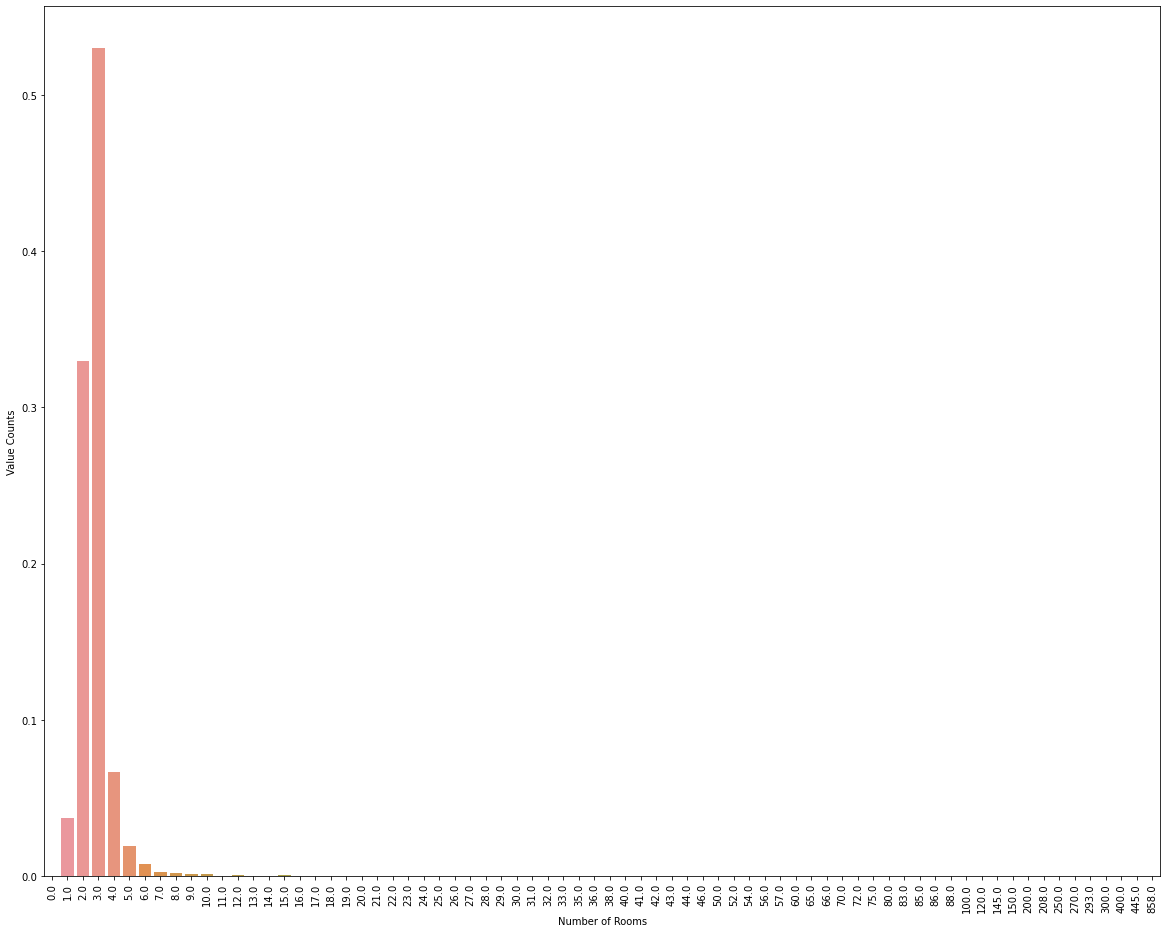

In [15]:
room = data["rooms"].value_counts(normalize= True).sort_index()

plt.figure(figsize=(20,16))
sns.barplot(room.index, room.values)
plt.xlabel("Number of Rooms")
plt.xticks(rotation=90)

plt.ylabel("Value Counts")

plt.show()

In [16]:
mod_room = data["rooms"].mode()[0]

data["rooms"].replace(np.nan, mod_room, inplace= True)
data.reset_index(inplace=True, drop=True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299011 entries, 0 to 299010
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    299011 non-null  object 
 1   prices       299011 non-null  float64
 2   Price_per_m  299011 non-null  float64
 3   sizes        299011 non-null  float64
 4   rooms        299011 non-null  float64
 5   bathrooms    261581 non-null  float64
 6   finishes     281813 non-null  object 
 7   views        291548 non-null  object 
 8   floors       252921 non-null  object 
 9   years        283117 non-null  float64
 10  payments     297891 non-null  object 
dtypes: float64(6), object(5)
memory usage: 25.1+ MB


###### Bathrooms

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


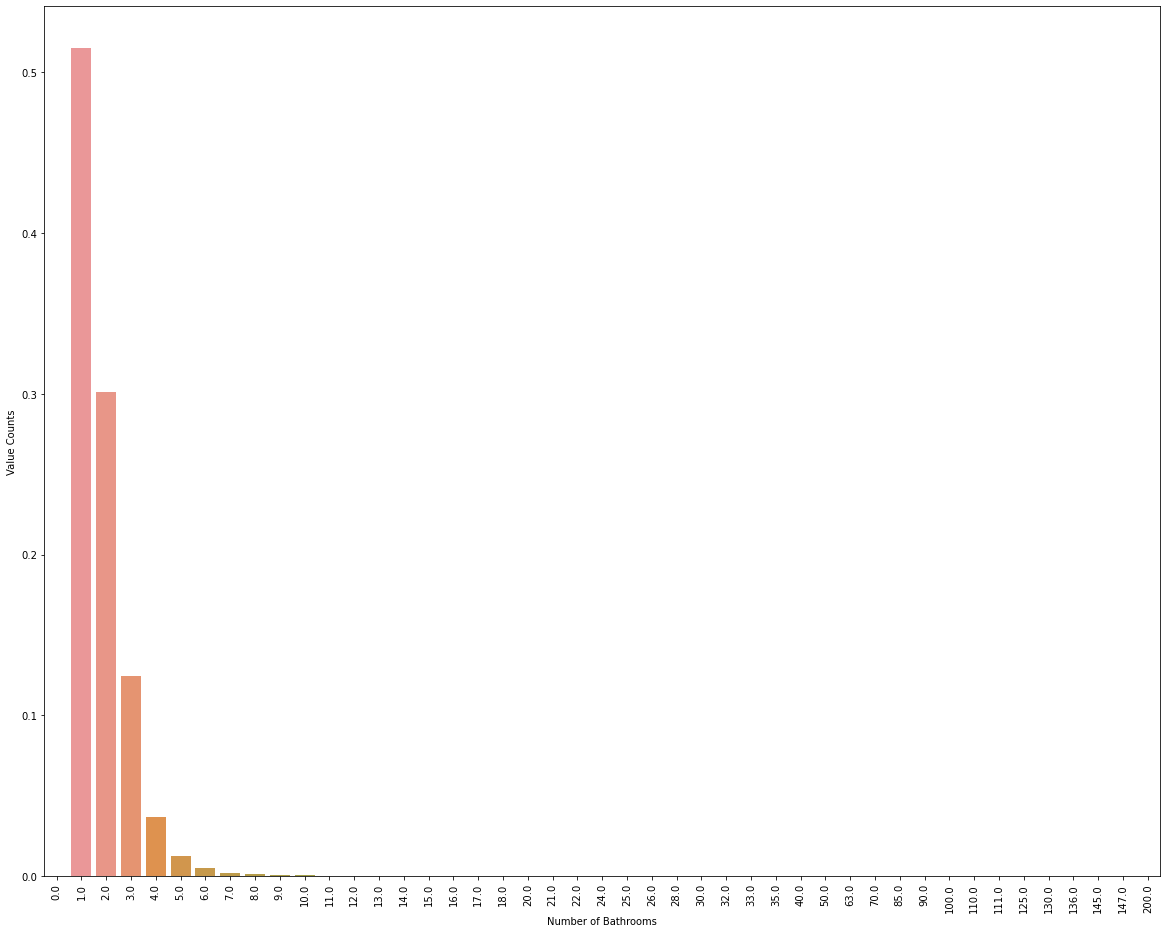

In [18]:
bathroom = data["bathrooms"].value_counts(normalize= True).sort_index()

plt.figure(figsize=(20,16))
sns.barplot(bathroom.index, bathroom.values)
plt.xlabel("Number of Bathrooms")
plt.xticks(rotation=90)

plt.ylabel("Value Counts")

plt.show()

In [19]:
mod_bathroom = data["bathrooms"].mode()[0]

data["bathrooms"].replace(np.nan, mod_bathroom, inplace= True)
data.reset_index(inplace=True, drop=True)
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo,3600000.0,24827.0,145.0,3.0,3.0,Extra Super Lux,Garden,3,2025.0,Cash
1,Greater Cairo,9500000.0,54285.0,175.0,3.0,3.0,Semi Finished,Main Street,4,2026.0,Cash or Installments
2,North Coast,34636000.0,193497.0,179.0,3.0,1.0,Extra super lux,Seaview,NaN,2027.0,Cash or Installments
3,Greater Cairo,5125000.0,35344.0,145.0,3.0,2.0,Extra Super Lux,Garden,2,2023.0,Cash or Installments
4,Greater Cairo,17607000.0,110735.0,159.0,3.0,1.0,Without Finish,Main Street,3,2026.0,Cash or Installments
...,...,...,...,...,...,...,...,...,...,...,...
299006,Greater Cairo,1500000.0,12500.0,120.0,3.0,1.0,Super Lux,Other,8,2016.0,Cash
299007,Alexandria,770000.0,8555.0,90.0,2.0,1.0,Super Lux,Other,8,2021.0,Cash
299008,Alexandria,220000.0,2750.0,80.0,2.0,1.0,Super Lux,Other,3,2017.0,Cash
299009,Alexandria,4500000.0,20454.0,220.0,3.0,2.0,Super Lux,Other,9,2010.0,Cash


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299011 entries, 0 to 299010
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    299011 non-null  object 
 1   prices       299011 non-null  float64
 2   Price_per_m  299011 non-null  float64
 3   sizes        299011 non-null  float64
 4   rooms        299011 non-null  float64
 5   bathrooms    299011 non-null  float64
 6   finishes     281813 non-null  object 
 7   views        291548 non-null  object 
 8   floors       252921 non-null  object 
 9   years        283117 non-null  float64
 10  payments     297891 non-null  object 
dtypes: float64(6), object(5)
memory usage: 25.1+ MB


###### Floors

In [21]:
## convert ground floor to value 0
data.loc[data["floors"]== "Ground", "floors"] = 0

In [22]:
data["floors"].replace('12,13', np.nan, inplace= True)
data["floors"].replace('9,10', np.nan, inplace= True)
data["floors"].replace('5.6', np.nan, inplace= True)

data["floors"] = data["floors"].astype(float)

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


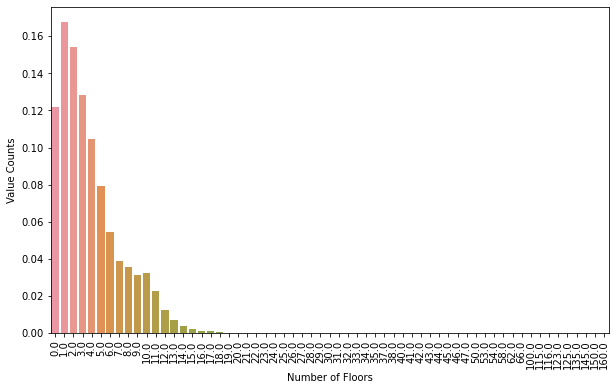

In [23]:
floor = data["floors"].astype(float).value_counts(normalize= True).sort_index()


plt.figure(figsize=(10,6))
sns.barplot(floor.index, floor.values)
plt.xlabel("Number of Floors")
plt.xticks(rotation=90)

plt.ylabel("Value Counts")

plt.show()

In [24]:
mod_floor = data["floors"].mode()[0]

data["floors"].replace(np.nan, mod_floor, inplace= True)
data.reset_index(inplace=True, drop=True)
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo,3600000.0,24827.0,145.0,3.0,3.0,Extra Super Lux,Garden,3.0,2025.0,Cash
1,Greater Cairo,9500000.0,54285.0,175.0,3.0,3.0,Semi Finished,Main Street,4.0,2026.0,Cash or Installments
2,North Coast,34636000.0,193497.0,179.0,3.0,1.0,Extra super lux,Seaview,1.0,2027.0,Cash or Installments
3,Greater Cairo,5125000.0,35344.0,145.0,3.0,2.0,Extra Super Lux,Garden,2.0,2023.0,Cash or Installments
4,Greater Cairo,17607000.0,110735.0,159.0,3.0,1.0,Without Finish,Main Street,3.0,2026.0,Cash or Installments
...,...,...,...,...,...,...,...,...,...,...,...
299006,Greater Cairo,1500000.0,12500.0,120.0,3.0,1.0,Super Lux,Other,8.0,2016.0,Cash
299007,Alexandria,770000.0,8555.0,90.0,2.0,1.0,Super Lux,Other,8.0,2021.0,Cash
299008,Alexandria,220000.0,2750.0,80.0,2.0,1.0,Super Lux,Other,3.0,2017.0,Cash
299009,Alexandria,4500000.0,20454.0,220.0,3.0,2.0,Super Lux,Other,9.0,2010.0,Cash


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299011 entries, 0 to 299010
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    299011 non-null  object 
 1   prices       299011 non-null  float64
 2   Price_per_m  299011 non-null  float64
 3   sizes        299011 non-null  float64
 4   rooms        299011 non-null  float64
 5   bathrooms    299011 non-null  float64
 6   finishes     281813 non-null  object 
 7   views        291548 non-null  object 
 8   floors       299011 non-null  float64
 9   years        283117 non-null  float64
 10  payments     297891 non-null  object 
dtypes: float64(7), object(4)
memory usage: 25.1+ MB


###### Finish Type

In [26]:
data["finishes"].value_counts()

Super Lux          144415
Extra Super Lux     44448
Semi Finished       40418
Without Finish      27372
Lux                 21633
Extra super lux      3480
Super lux              47
Name: finishes, dtype: int64

In [27]:
data["finishes"].replace('Extra super lux', "Extra Super Lux", inplace= True)
data["finishes"].replace('Super lux', "Super Lux", inplace= True)

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


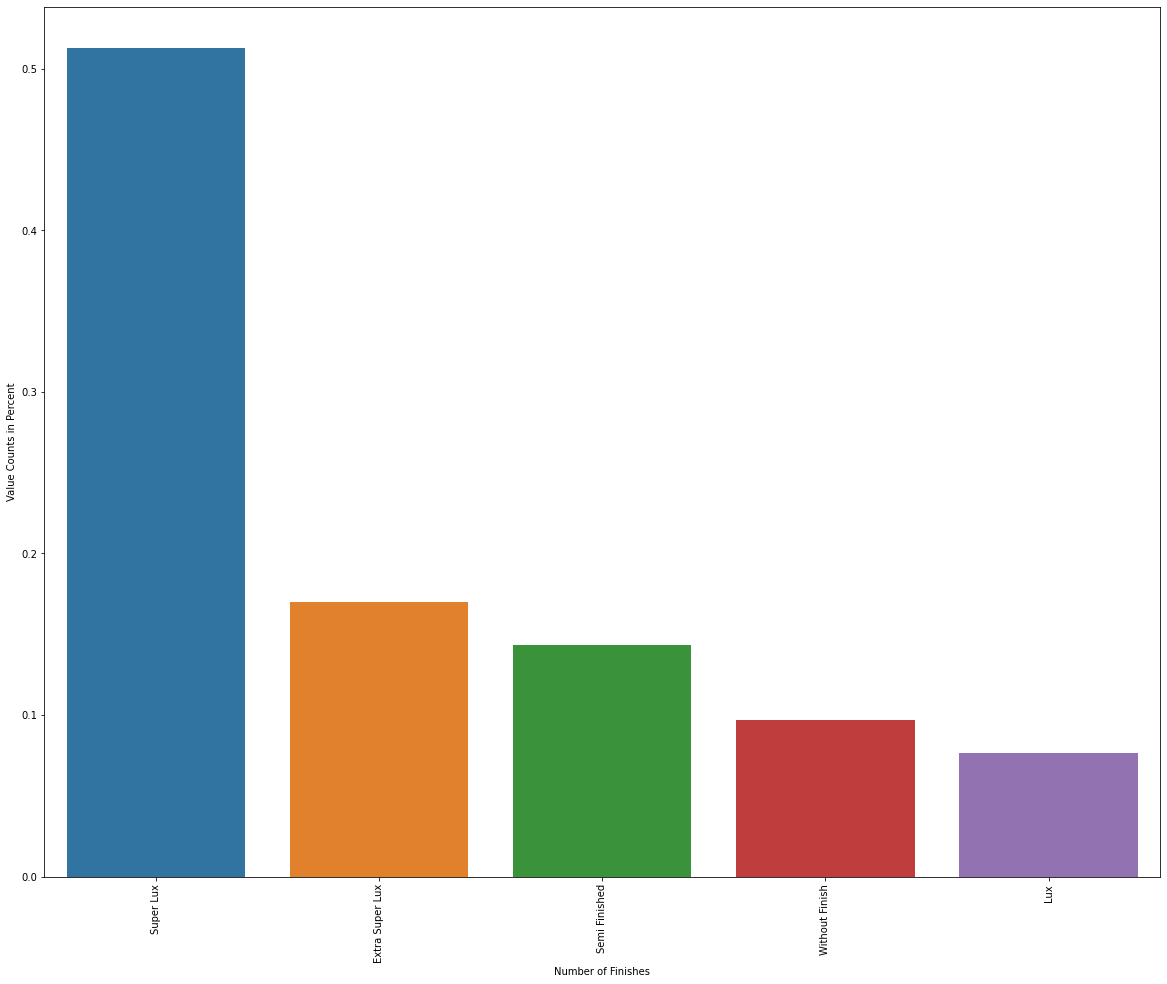

In [28]:
finish = data["finishes"].value_counts(normalize= True)


plt.figure(figsize=(20,16))
sns.barplot(finish.index, finish.values)
plt.xlabel("Number of Finishes")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

In [29]:
#Impute NaNs to without Finish

data["finishes"].replace(np.nan, "Without Finish", inplace= True)
data.reset_index(inplace=True, drop=True)
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo,3600000.0,24827.0,145.0,3.0,3.0,Extra Super Lux,Garden,3.0,2025.0,Cash
1,Greater Cairo,9500000.0,54285.0,175.0,3.0,3.0,Semi Finished,Main Street,4.0,2026.0,Cash or Installments
2,North Coast,34636000.0,193497.0,179.0,3.0,1.0,Extra Super Lux,Seaview,1.0,2027.0,Cash or Installments
3,Greater Cairo,5125000.0,35344.0,145.0,3.0,2.0,Extra Super Lux,Garden,2.0,2023.0,Cash or Installments
4,Greater Cairo,17607000.0,110735.0,159.0,3.0,1.0,Without Finish,Main Street,3.0,2026.0,Cash or Installments
...,...,...,...,...,...,...,...,...,...,...,...
299006,Greater Cairo,1500000.0,12500.0,120.0,3.0,1.0,Super Lux,Other,8.0,2016.0,Cash
299007,Alexandria,770000.0,8555.0,90.0,2.0,1.0,Super Lux,Other,8.0,2021.0,Cash
299008,Alexandria,220000.0,2750.0,80.0,2.0,1.0,Super Lux,Other,3.0,2017.0,Cash
299009,Alexandria,4500000.0,20454.0,220.0,3.0,2.0,Super Lux,Other,9.0,2010.0,Cash


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299011 entries, 0 to 299010
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    299011 non-null  object 
 1   prices       299011 non-null  float64
 2   Price_per_m  299011 non-null  float64
 3   sizes        299011 non-null  float64
 4   rooms        299011 non-null  float64
 5   bathrooms    299011 non-null  float64
 6   finishes     299011 non-null  object 
 7   views        291548 non-null  object 
 8   floors       299011 non-null  float64
 9   years        283117 non-null  float64
 10  payments     297891 non-null  object 
dtypes: float64(7), object(4)
memory usage: 25.1+ MB


###### Prices & Sizes

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


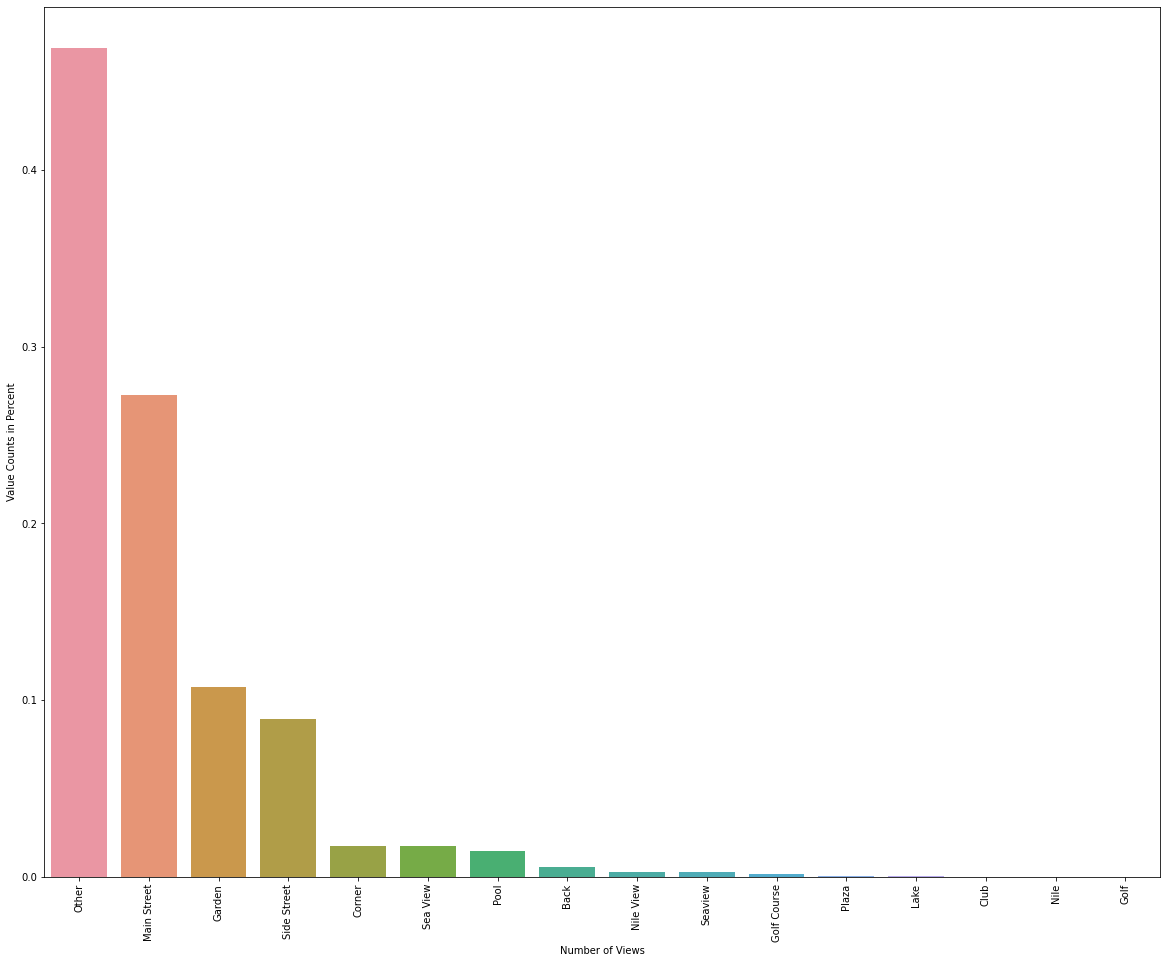

In [31]:
view = data["views"].value_counts(normalize= True)


plt.figure(figsize=(20,16))
sns.barplot(view.index, view.values)
plt.xlabel("Number of Views")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

In [32]:
mode_view = data["views"].mode()[0]

data["views"].replace(np.nan, "Other", inplace= True)
data.reset_index(inplace=True, drop=True)
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo,3600000.0,24827.0,145.0,3.0,3.0,Extra Super Lux,Garden,3.0,2025.0,Cash
1,Greater Cairo,9500000.0,54285.0,175.0,3.0,3.0,Semi Finished,Main Street,4.0,2026.0,Cash or Installments
2,North Coast,34636000.0,193497.0,179.0,3.0,1.0,Extra Super Lux,Seaview,1.0,2027.0,Cash or Installments
3,Greater Cairo,5125000.0,35344.0,145.0,3.0,2.0,Extra Super Lux,Garden,2.0,2023.0,Cash or Installments
4,Greater Cairo,17607000.0,110735.0,159.0,3.0,1.0,Without Finish,Main Street,3.0,2026.0,Cash or Installments
...,...,...,...,...,...,...,...,...,...,...,...
299006,Greater Cairo,1500000.0,12500.0,120.0,3.0,1.0,Super Lux,Other,8.0,2016.0,Cash
299007,Alexandria,770000.0,8555.0,90.0,2.0,1.0,Super Lux,Other,8.0,2021.0,Cash
299008,Alexandria,220000.0,2750.0,80.0,2.0,1.0,Super Lux,Other,3.0,2017.0,Cash
299009,Alexandria,4500000.0,20454.0,220.0,3.0,2.0,Super Lux,Other,9.0,2010.0,Cash


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299011 entries, 0 to 299010
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    299011 non-null  object 
 1   prices       299011 non-null  float64
 2   Price_per_m  299011 non-null  float64
 3   sizes        299011 non-null  float64
 4   rooms        299011 non-null  float64
 5   bathrooms    299011 non-null  float64
 6   finishes     299011 non-null  object 
 7   views        299011 non-null  object 
 8   floors       299011 non-null  float64
 9   years        283117 non-null  float64
 10  payments     297891 non-null  object 
dtypes: float64(7), object(4)
memory usage: 25.1+ MB


###### Payment Type

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


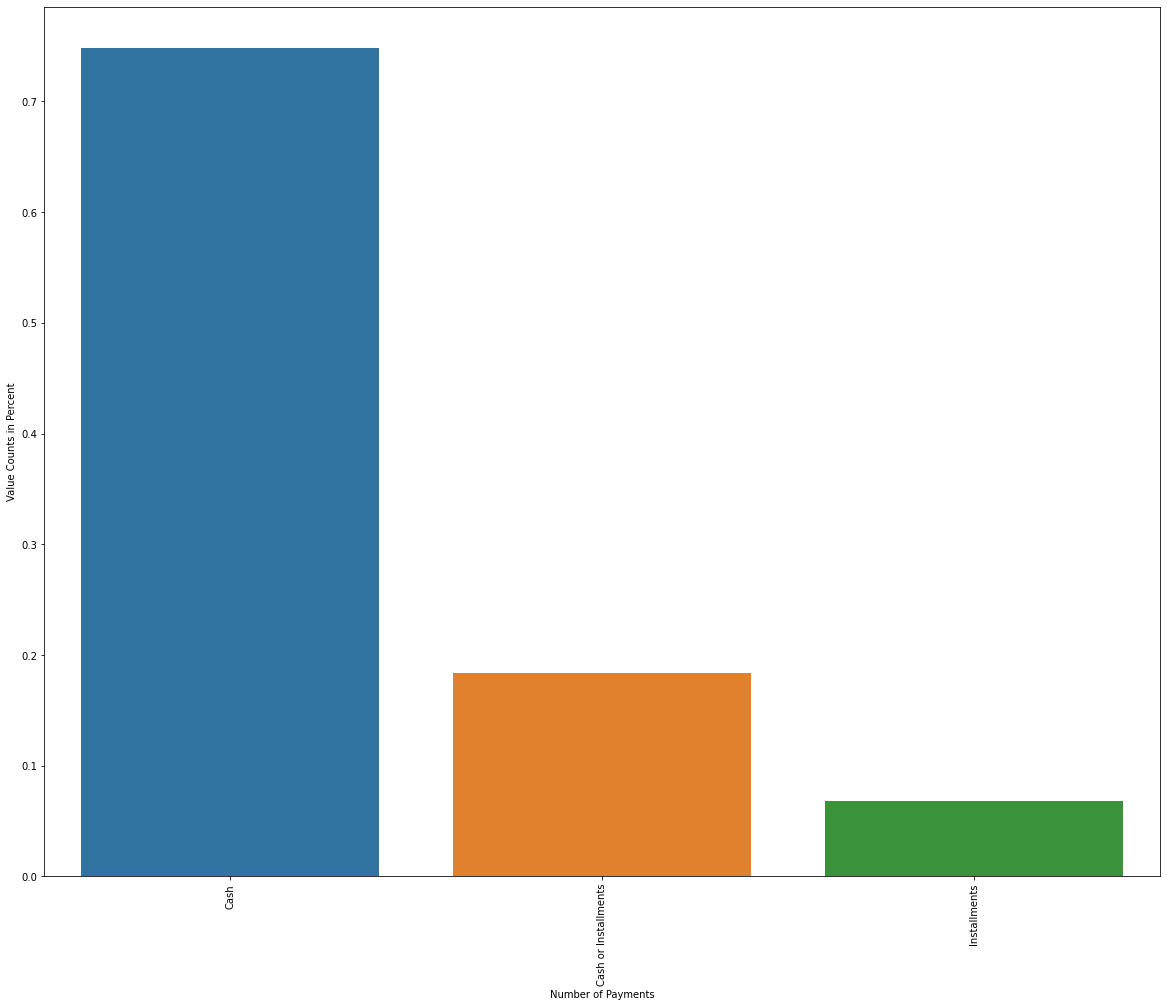

In [34]:
payment = data["payments"].value_counts(normalize= True)


plt.figure(figsize=(20,16))
sns.barplot(payment.index, payment.values)
plt.xlabel("Number of Payments")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

In [35]:
mode_payment = data["payments"].mode()[0]

data["payments"].replace(np.nan, mode_payment, inplace= True)
data.reset_index(inplace=True, drop=True)
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo,3600000.0,24827.0,145.0,3.0,3.0,Extra Super Lux,Garden,3.0,2025.0,Cash
1,Greater Cairo,9500000.0,54285.0,175.0,3.0,3.0,Semi Finished,Main Street,4.0,2026.0,Cash or Installments
2,North Coast,34636000.0,193497.0,179.0,3.0,1.0,Extra Super Lux,Seaview,1.0,2027.0,Cash or Installments
3,Greater Cairo,5125000.0,35344.0,145.0,3.0,2.0,Extra Super Lux,Garden,2.0,2023.0,Cash or Installments
4,Greater Cairo,17607000.0,110735.0,159.0,3.0,1.0,Without Finish,Main Street,3.0,2026.0,Cash or Installments
...,...,...,...,...,...,...,...,...,...,...,...
299006,Greater Cairo,1500000.0,12500.0,120.0,3.0,1.0,Super Lux,Other,8.0,2016.0,Cash
299007,Alexandria,770000.0,8555.0,90.0,2.0,1.0,Super Lux,Other,8.0,2021.0,Cash
299008,Alexandria,220000.0,2750.0,80.0,2.0,1.0,Super Lux,Other,3.0,2017.0,Cash
299009,Alexandria,4500000.0,20454.0,220.0,3.0,2.0,Super Lux,Other,9.0,2010.0,Cash


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299011 entries, 0 to 299010
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    299011 non-null  object 
 1   prices       299011 non-null  float64
 2   Price_per_m  299011 non-null  float64
 3   sizes        299011 non-null  float64
 4   rooms        299011 non-null  float64
 5   bathrooms    299011 non-null  float64
 6   finishes     299011 non-null  object 
 7   views        299011 non-null  object 
 8   floors       299011 non-null  float64
 9   years        283117 non-null  float64
 10  payments     299011 non-null  object 
dtypes: float64(7), object(4)
memory usage: 25.1+ MB


###### Years

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


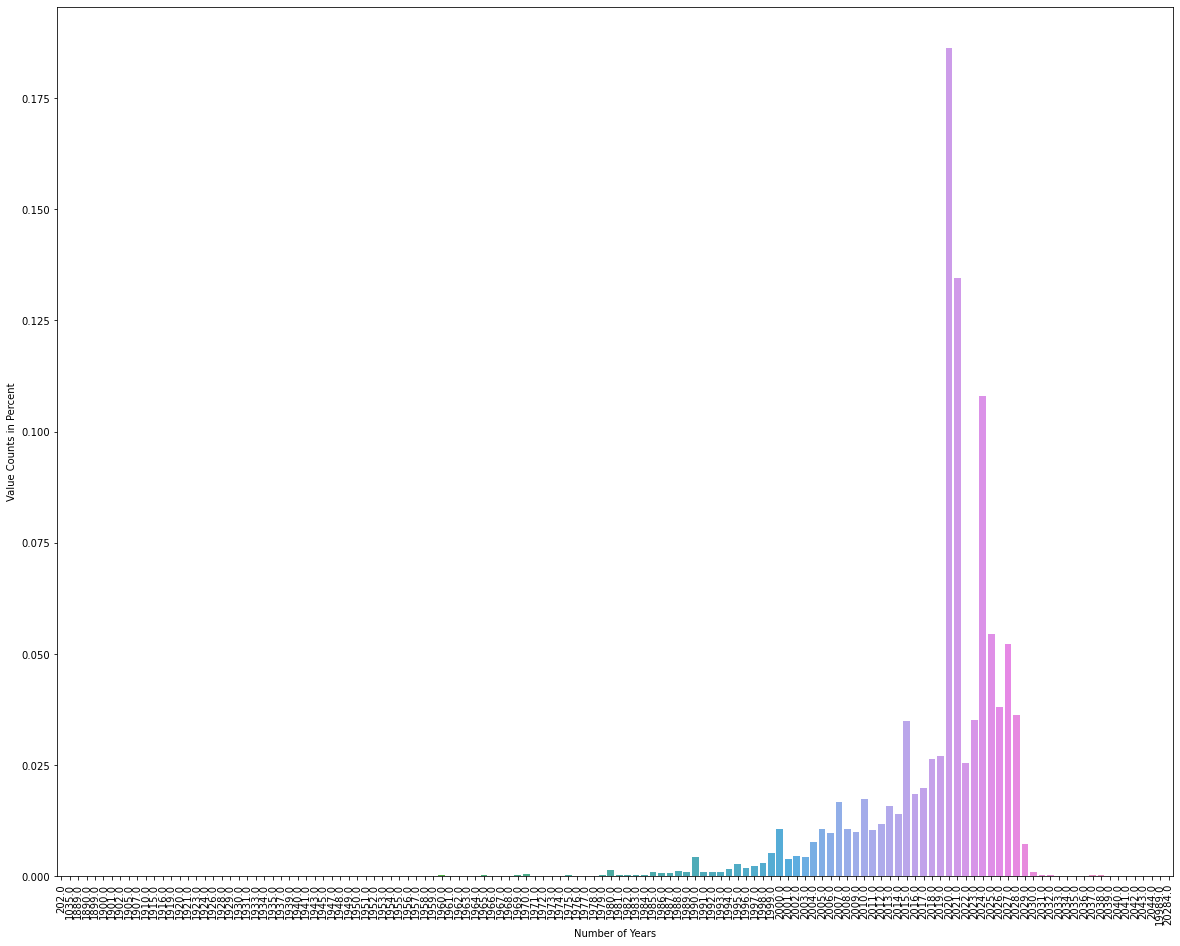

In [37]:
year_ranges = data["years"].value_counts(normalize= True).sort_index()


plt.figure(figsize=(20,16))
sns.barplot(year_ranges.index, year_ranges.values)
plt.xlabel("Number of Years")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

In [38]:
mode_year = data["years"].mode()[0]

data["years"].replace(np.nan, mode_year, inplace= True)
data.reset_index(inplace=True, drop=True)
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo,3600000.0,24827.0,145.0,3.0,3.0,Extra Super Lux,Garden,3.0,2025.0,Cash
1,Greater Cairo,9500000.0,54285.0,175.0,3.0,3.0,Semi Finished,Main Street,4.0,2026.0,Cash or Installments
2,North Coast,34636000.0,193497.0,179.0,3.0,1.0,Extra Super Lux,Seaview,1.0,2027.0,Cash or Installments
3,Greater Cairo,5125000.0,35344.0,145.0,3.0,2.0,Extra Super Lux,Garden,2.0,2023.0,Cash or Installments
4,Greater Cairo,17607000.0,110735.0,159.0,3.0,1.0,Without Finish,Main Street,3.0,2026.0,Cash or Installments
...,...,...,...,...,...,...,...,...,...,...,...
299006,Greater Cairo,1500000.0,12500.0,120.0,3.0,1.0,Super Lux,Other,8.0,2016.0,Cash
299007,Alexandria,770000.0,8555.0,90.0,2.0,1.0,Super Lux,Other,8.0,2021.0,Cash
299008,Alexandria,220000.0,2750.0,80.0,2.0,1.0,Super Lux,Other,3.0,2017.0,Cash
299009,Alexandria,4500000.0,20454.0,220.0,3.0,2.0,Super Lux,Other,9.0,2010.0,Cash


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299011 entries, 0 to 299010
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    299011 non-null  object 
 1   prices       299011 non-null  float64
 2   Price_per_m  299011 non-null  float64
 3   sizes        299011 non-null  float64
 4   rooms        299011 non-null  float64
 5   bathrooms    299011 non-null  float64
 6   finishes     299011 non-null  object 
 7   views        299011 non-null  object 
 8   floors       299011 non-null  float64
 9   years        299011 non-null  float64
 10  payments     299011 non-null  object 
dtypes: float64(7), object(4)
memory usage: 25.1+ MB


In [40]:
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo,3600000.0,24827.0,145.0,3.0,3.0,Extra Super Lux,Garden,3.0,2025.0,Cash
1,Greater Cairo,9500000.0,54285.0,175.0,3.0,3.0,Semi Finished,Main Street,4.0,2026.0,Cash or Installments
2,North Coast,34636000.0,193497.0,179.0,3.0,1.0,Extra Super Lux,Seaview,1.0,2027.0,Cash or Installments
3,Greater Cairo,5125000.0,35344.0,145.0,3.0,2.0,Extra Super Lux,Garden,2.0,2023.0,Cash or Installments
4,Greater Cairo,17607000.0,110735.0,159.0,3.0,1.0,Without Finish,Main Street,3.0,2026.0,Cash or Installments
...,...,...,...,...,...,...,...,...,...,...,...
299006,Greater Cairo,1500000.0,12500.0,120.0,3.0,1.0,Super Lux,Other,8.0,2016.0,Cash
299007,Alexandria,770000.0,8555.0,90.0,2.0,1.0,Super Lux,Other,8.0,2021.0,Cash
299008,Alexandria,220000.0,2750.0,80.0,2.0,1.0,Super Lux,Other,3.0,2017.0,Cash
299009,Alexandria,4500000.0,20454.0,220.0,3.0,2.0,Super Lux,Other,9.0,2010.0,Cash


In [41]:
data.isna().sum()

locations      0
prices         0
Price_per_m    0
sizes          0
rooms          0
bathrooms      0
finishes       0
views          0
floors         0
years          0
payments       0
dtype: int64

# Encoding

###### Locations

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


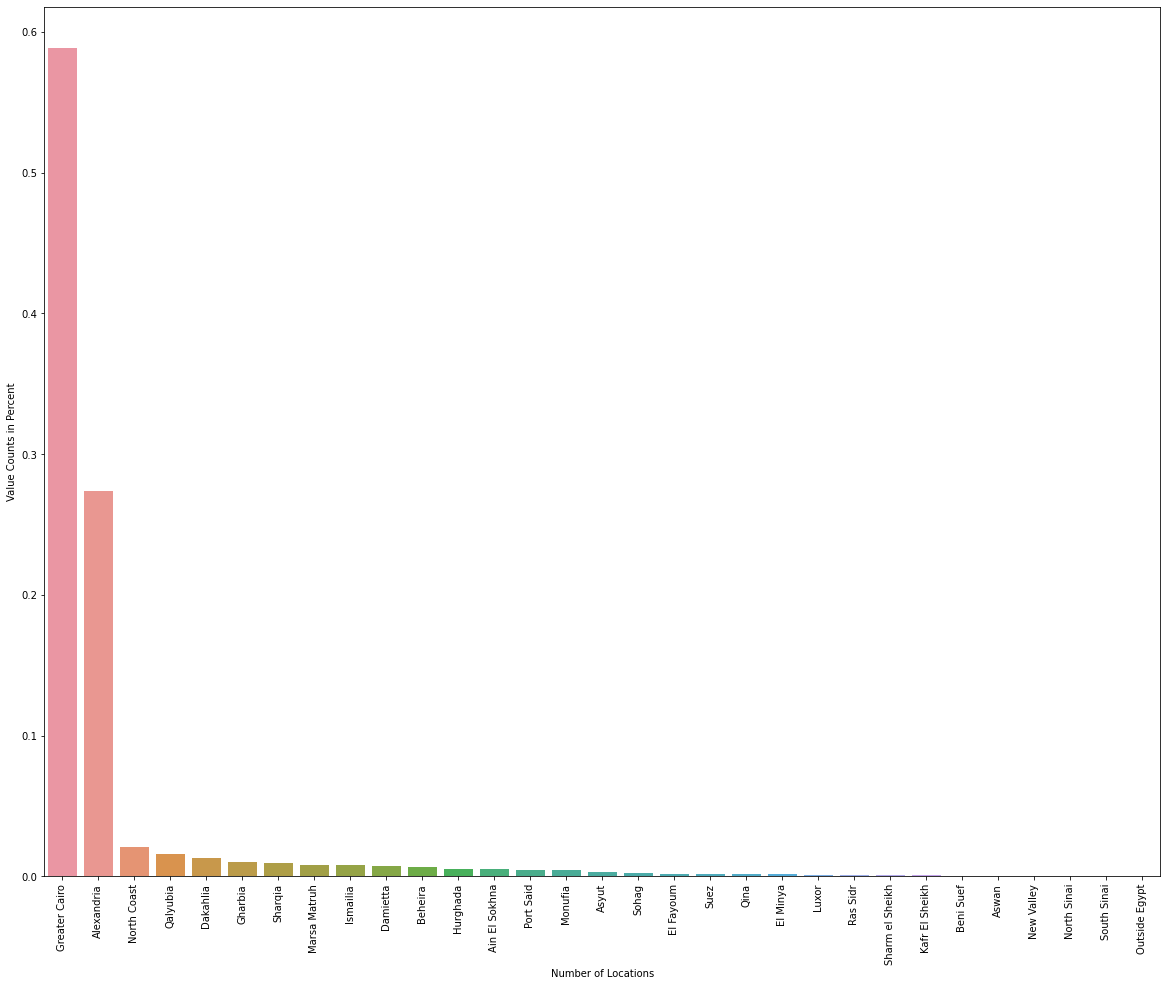

In [42]:
location = data["locations"].value_counts(normalize= True)


plt.figure(figsize=(20,16))
sns.barplot(location.index, location.values)
plt.xlabel("Number of Locations")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

In [43]:
# Slice Non Cairo And Alexandria Properties
not_valid_location = data[~((data["locations"] == "Alexandria") | (data["locations"] == "Greater Cairo") | (data["locations"] == "North Coast"))]

## Convert any other locations to 0 value
data.loc[not_valid_location.index, "locations"] = "other"

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


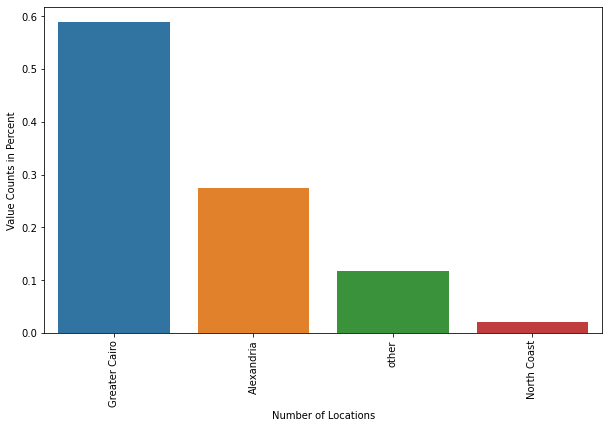

In [44]:
location = data["locations"].value_counts(normalize= True)


plt.figure(figsize=(10,6))
sns.barplot(location.index, location.values)
plt.xlabel("Number of Locations")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

###### Rooms

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


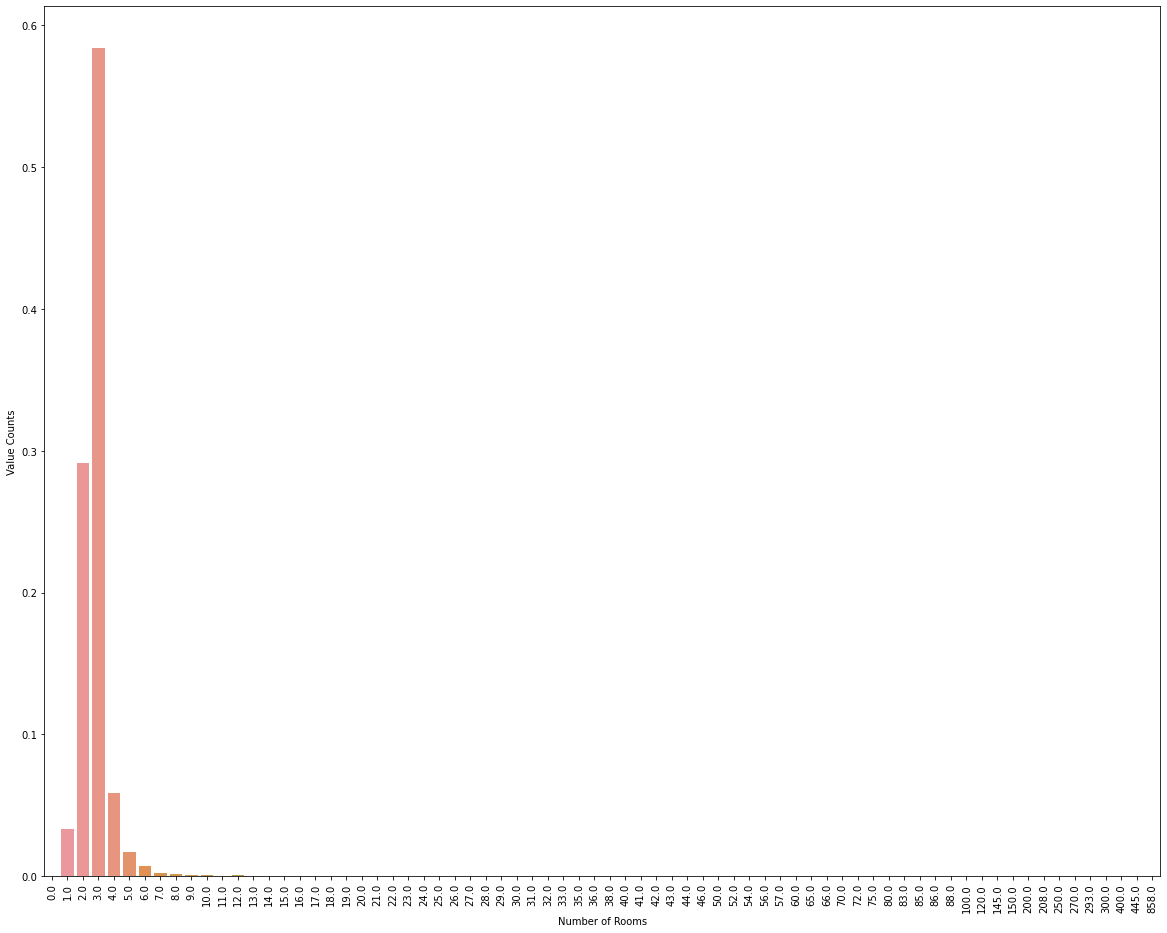

In [45]:
room = data["rooms"].value_counts(normalize= True).sort_index()

plt.figure(figsize=(20,16))
sns.barplot(room.index, room.values)
plt.xlabel("Number of Rooms")
plt.xticks(rotation=90)

plt.ylabel("Value Counts")

plt.show()

In [46]:
## Took Categories fron 1 to 5 only
data.drop(data[~((data["rooms"] < 6) & (data["rooms"] >0))].index, inplace=True, axis=0)
data.reset_index(drop= True, inplace= True)

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


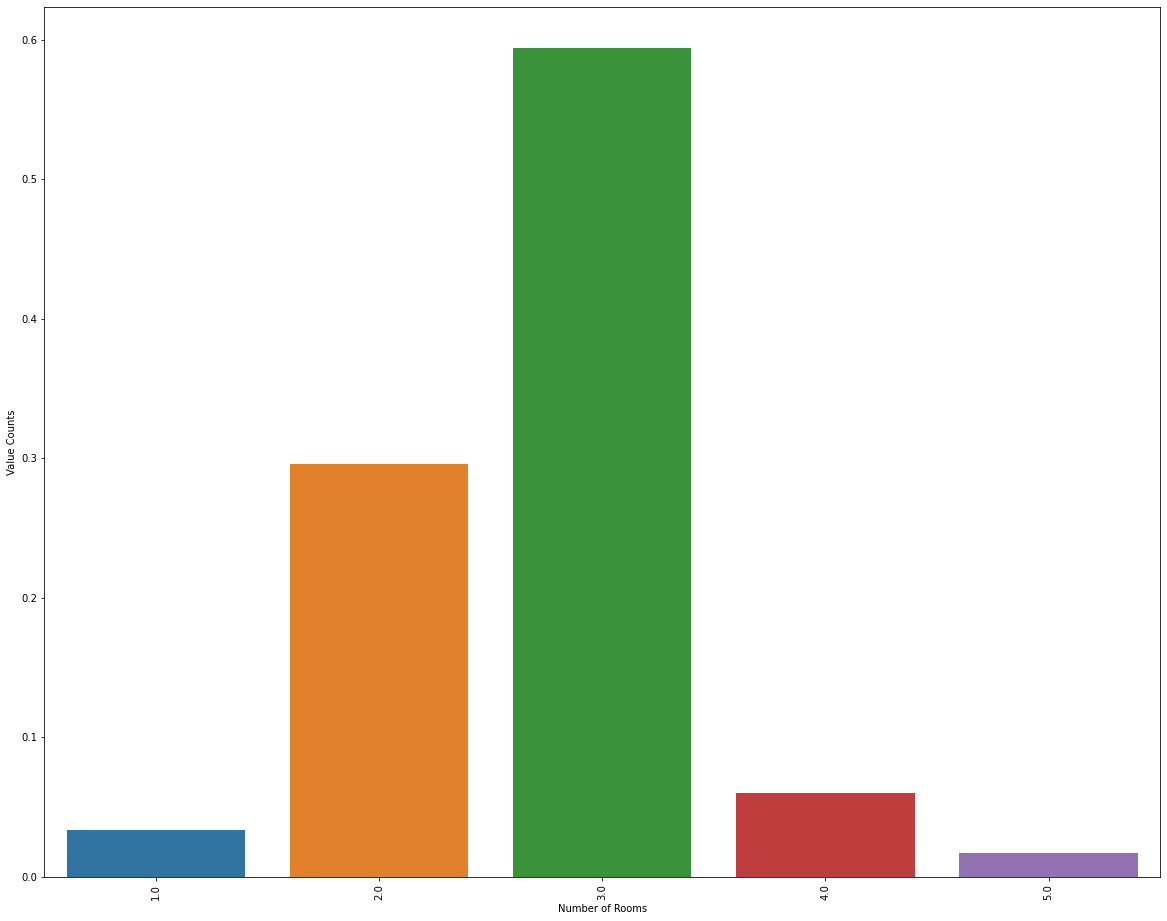

In [47]:
room = data["rooms"].value_counts(normalize= True).sort_index()

plt.figure(figsize=(20,16))
sns.barplot(room.index, room.values)
plt.xlabel("Number of Rooms")
plt.xticks(rotation=90)

plt.ylabel("Value Counts")

plt.show()

###### Bathrooms

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


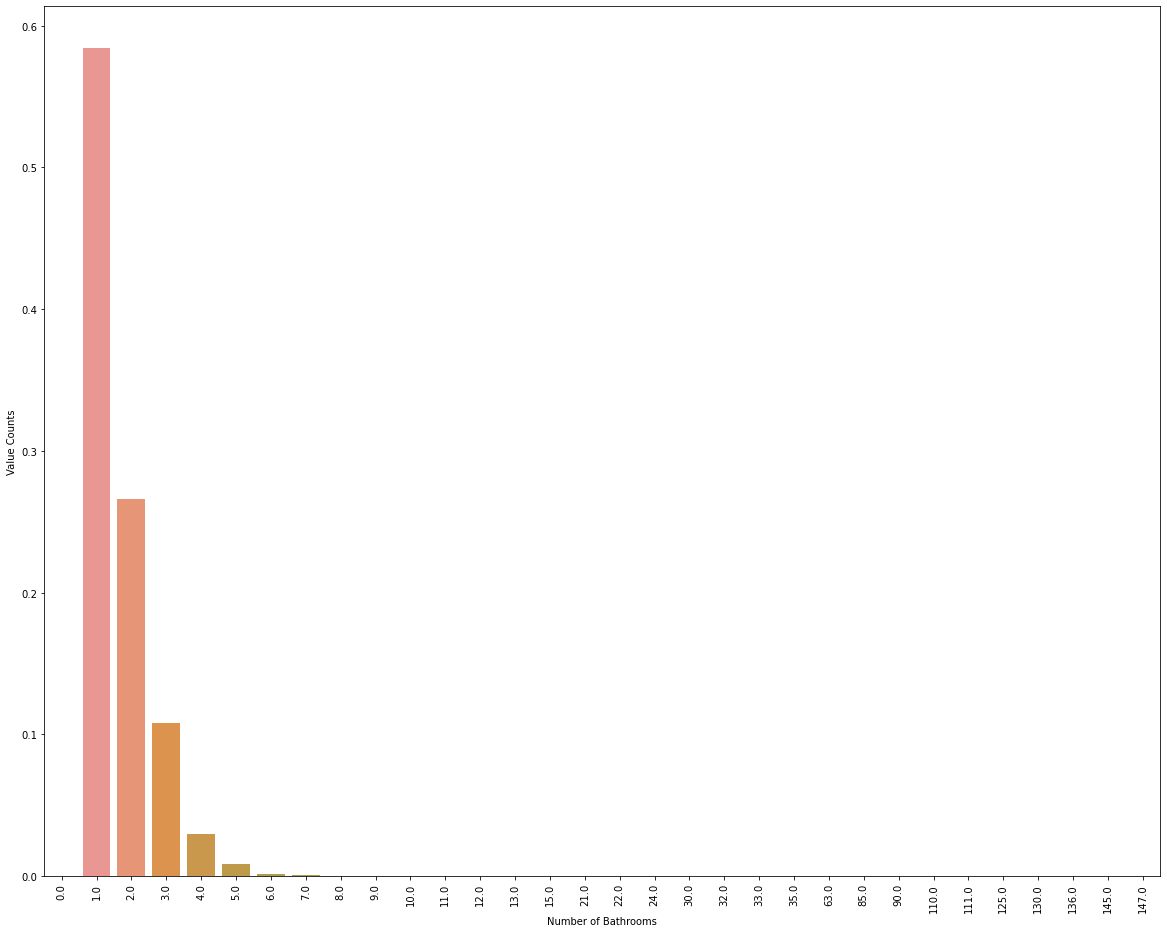

In [48]:
room = data["bathrooms"].value_counts(normalize= True).sort_index()

plt.figure(figsize=(20,16))
sns.barplot(room.index, room.values)
plt.xlabel("Number of Bathrooms")
plt.xticks(rotation=90)

plt.ylabel("Value Counts")

plt.show()

In [49]:
## Took Categories fron 1 to 5 only
data.drop(data[~((data["bathrooms"] < 6) & (data["bathrooms"] >0))].index, inplace=True, axis=0)
data.reset_index(drop= True, inplace= True)

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


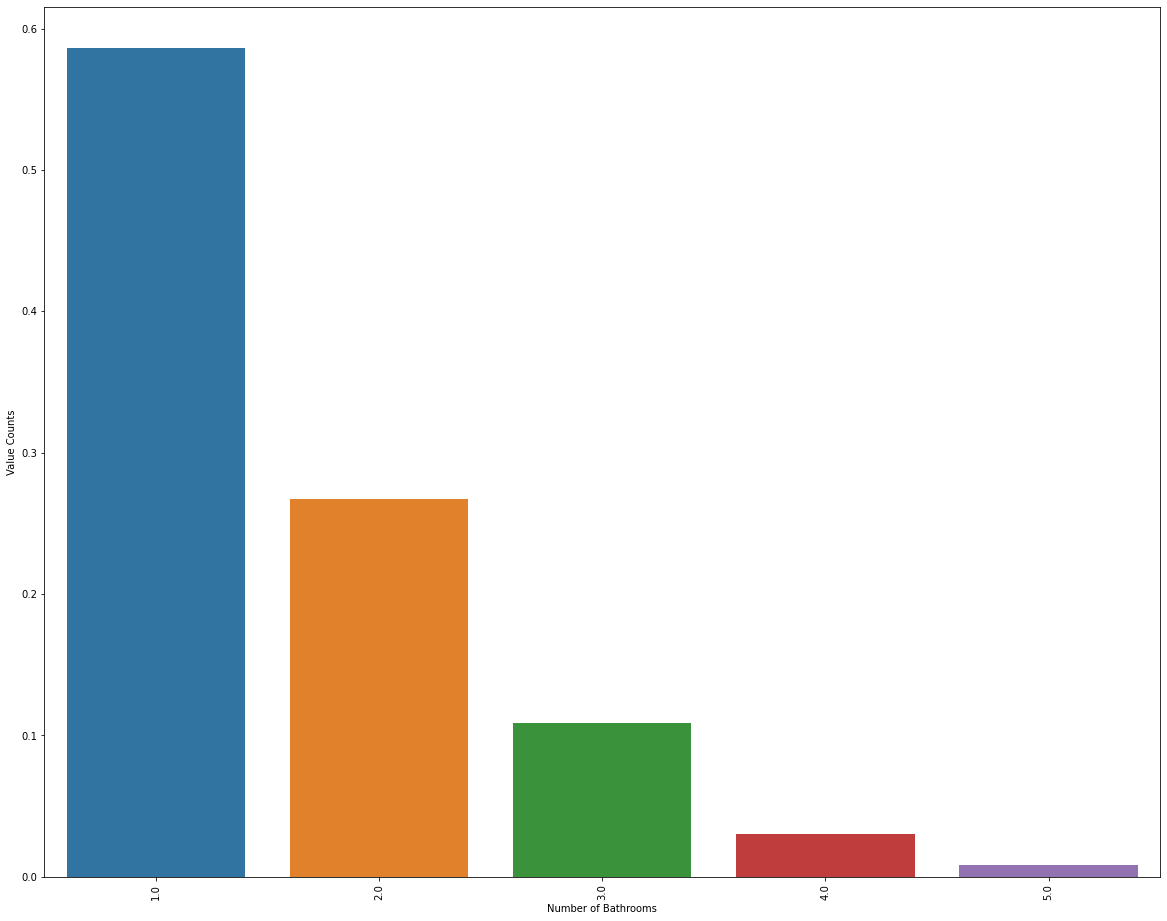

In [50]:
room = data["bathrooms"].value_counts(normalize= True).sort_index()

plt.figure(figsize=(20,16))
sns.barplot(room.index, room.values)
plt.xlabel("Number of Bathrooms")
plt.xticks(rotation=90)

plt.ylabel("Value Counts")

plt.show()

###### Floors

In [51]:
## convert ground floor to value 0
data.loc[data["floors"]== "Ground", "floors"] = 0

In [52]:
data["floors"].replace('12,13', np.nan, inplace= True)
data["floors"].replace('9,10', np.nan, inplace= True)
data["floors"].replace('5.6', np.nan, inplace= True)

data["floors"] = data["floors"].astype(float)

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


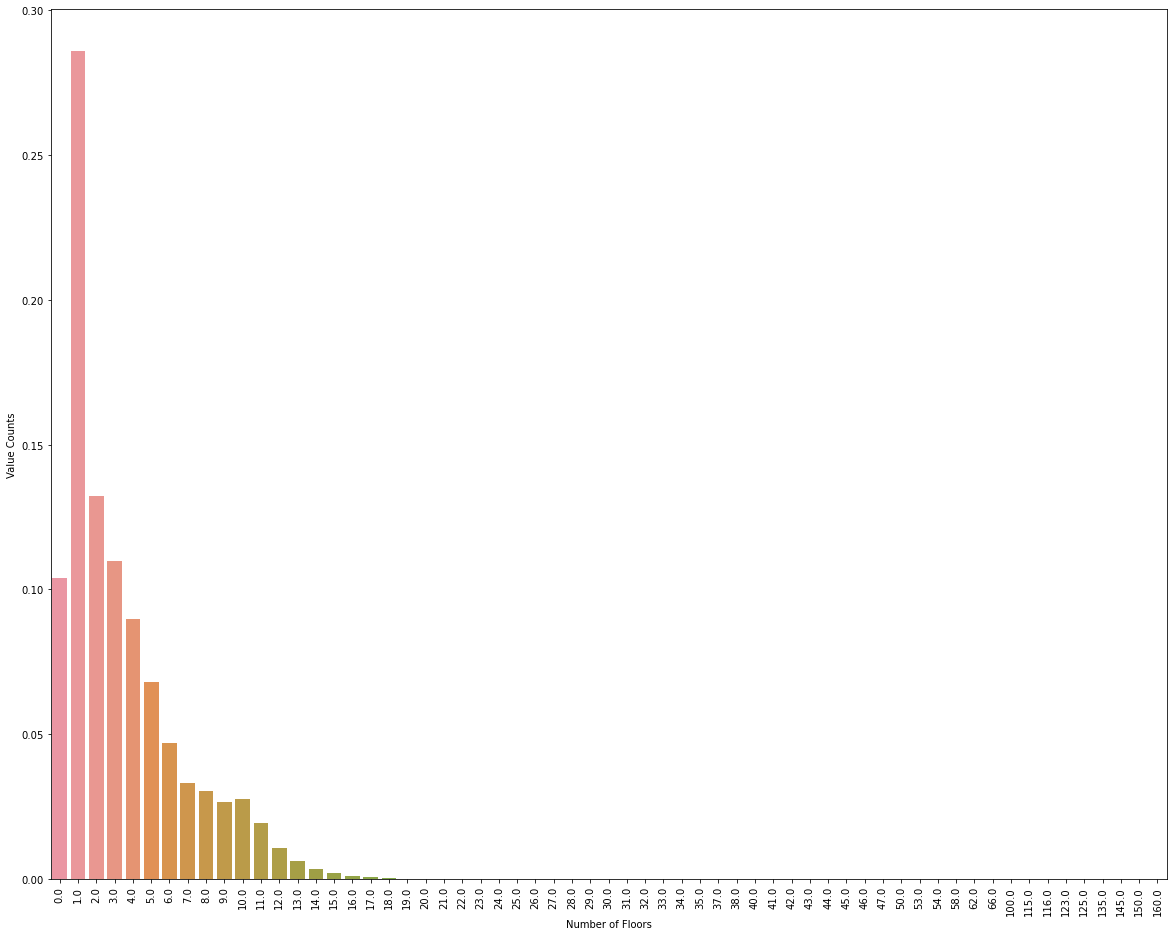

In [53]:
floor = data["floors"].astype(float).value_counts(normalize= True).sort_index()


plt.figure(figsize=(20,16))
sns.barplot(floor.index, floor.values)
plt.xlabel("Number of Floors")
plt.xticks(rotation=90)

plt.ylabel("Value Counts")

plt.show()

In [54]:
## Took Categories fron 0 to 10 only
data.drop(data[~(data["floors"] < 11)].index, inplace=True, axis=0)
data.reset_index(drop= True, inplace= True)

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


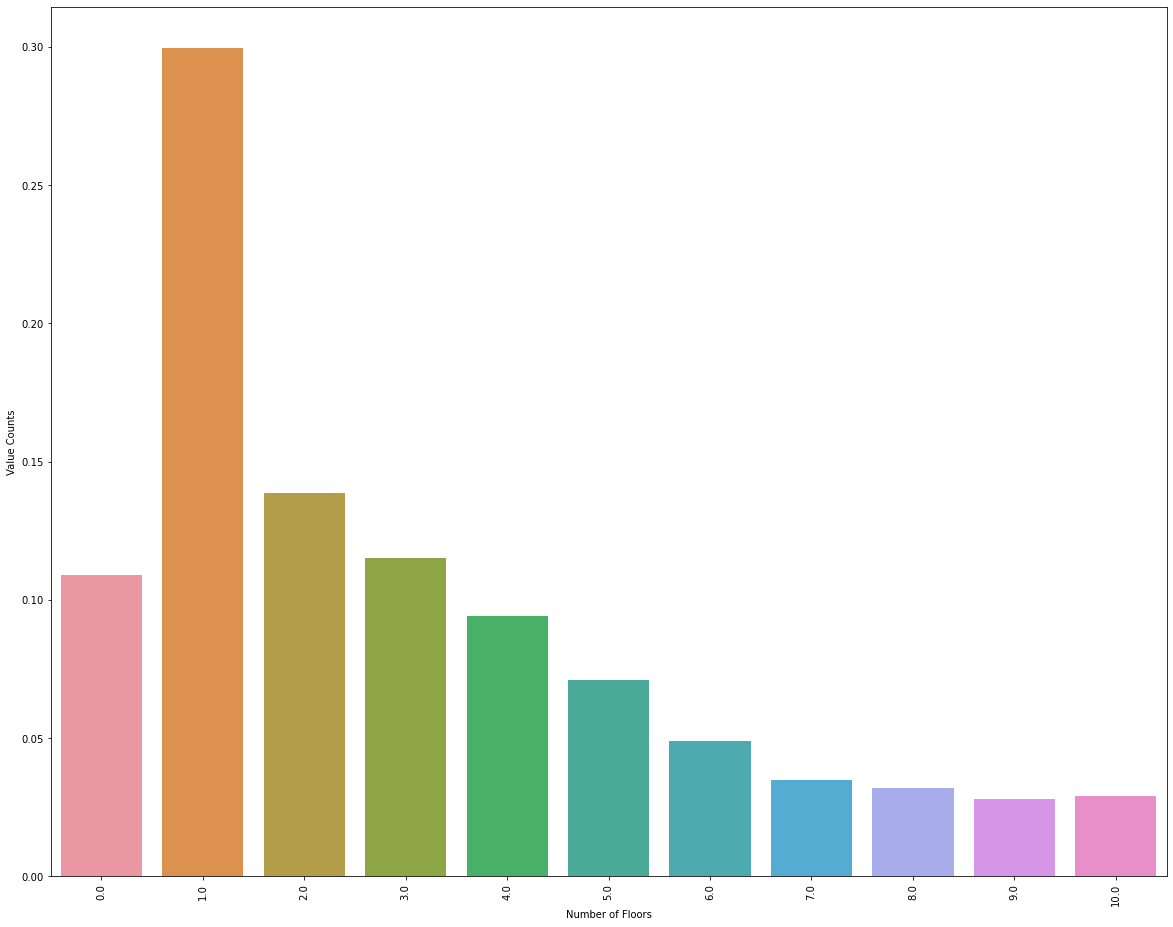

In [55]:
floor = data["floors"].astype(float).value_counts(normalize= True).sort_index()


plt.figure(figsize=(20,16))
sns.barplot(floor.index, floor.values)
plt.xlabel("Number of Floors")
plt.xticks(rotation=90)

plt.ylabel("Value Counts")

plt.show()

###### Finishes

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


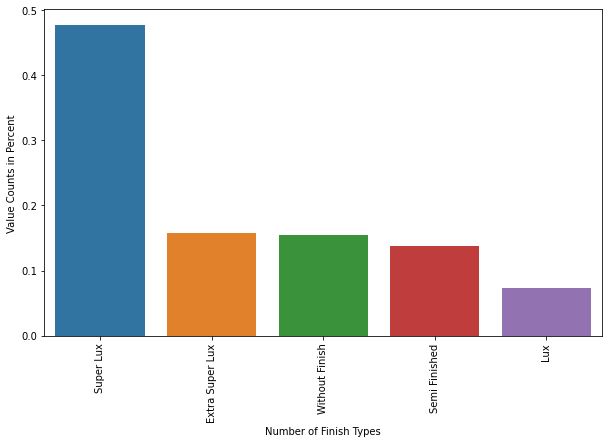

In [56]:
finish = data["finishes"].value_counts(normalize= True)


plt.figure(figsize=(10,6))
sns.barplot(finish.index, finish.values)
plt.xlabel("Number of Finish Types")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280412 entries, 0 to 280411
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    280412 non-null  object 
 1   prices       280412 non-null  float64
 2   Price_per_m  280412 non-null  float64
 3   sizes        280412 non-null  float64
 4   rooms        280412 non-null  float64
 5   bathrooms    280412 non-null  float64
 6   finishes     280412 non-null  object 
 7   views        280412 non-null  object 
 8   floors       280412 non-null  float64
 9   years        280412 non-null  float64
 10  payments     280412 non-null  object 
dtypes: float64(7), object(4)
memory usage: 23.5+ MB


###### Views

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


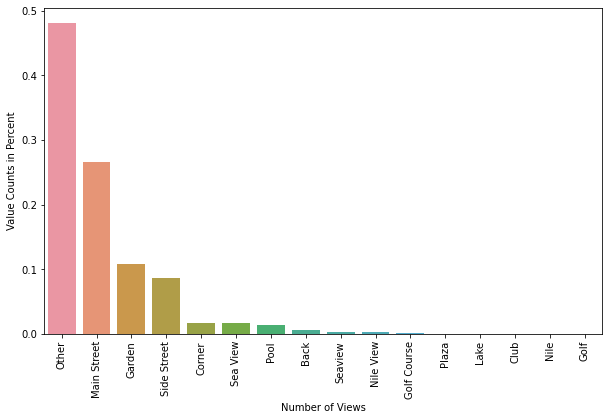

In [58]:
View = data["views"].value_counts(normalize= True)


plt.figure(figsize=(10,6))
sns.barplot(View.index, View.values)
plt.xlabel("Number of Views")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

In [59]:
## I will take first 7 categories only and convert others
high_view_cat = data["views"].value_counts()[:7].index
high_view_cat

## convert some views to Other
data.loc[~(data["views"].isin(high_view_cat)), "views"] = "Other"

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


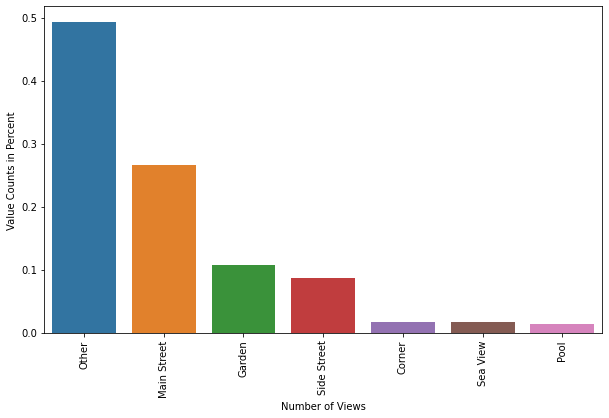

In [60]:
View = data["views"].value_counts(normalize= True)


plt.figure(figsize=(10,6))
sns.barplot(View.index, View.values)
plt.xlabel("Number of Views")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

###### Payment

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


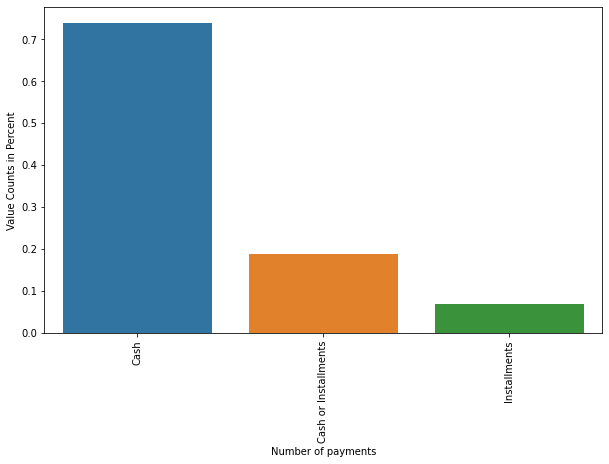

In [61]:
payment = data["payments"].value_counts(normalize= True)


plt.figure(figsize=(10,6))
sns.barplot(payment.index, payment.values)
plt.xlabel("Number of payments")
plt.xticks(rotation=90)

plt.ylabel("Value Counts in Percent")

plt.show()

### Dealing With Outliers

In [62]:
data

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo,3600000.0,24827.0,145.0,3.0,3.0,Extra Super Lux,Garden,3.0,2025.0,Cash
1,Greater Cairo,9500000.0,54285.0,175.0,3.0,3.0,Semi Finished,Main Street,4.0,2026.0,Cash or Installments
2,North Coast,34636000.0,193497.0,179.0,3.0,1.0,Extra Super Lux,Other,1.0,2027.0,Cash or Installments
3,Greater Cairo,5125000.0,35344.0,145.0,3.0,2.0,Extra Super Lux,Garden,2.0,2023.0,Cash or Installments
4,Greater Cairo,17607000.0,110735.0,159.0,3.0,1.0,Without Finish,Main Street,3.0,2026.0,Cash or Installments
...,...,...,...,...,...,...,...,...,...,...,...
280407,Greater Cairo,1500000.0,12500.0,120.0,3.0,1.0,Super Lux,Other,8.0,2016.0,Cash
280408,Alexandria,770000.0,8555.0,90.0,2.0,1.0,Super Lux,Other,8.0,2021.0,Cash
280409,Alexandria,220000.0,2750.0,80.0,2.0,1.0,Super Lux,Other,3.0,2017.0,Cash
280410,Alexandria,4500000.0,20454.0,220.0,3.0,2.0,Super Lux,Other,9.0,2010.0,Cash


In [63]:
## Handling Types of our features

data.iloc[:,1] = data.iloc[:,1].astype(float)
data.iloc[:,2] = data.iloc[:,2].astype(float)
data.iloc[:,3] = data.iloc[:,3].astype(int)
data.iloc[:,4] = data.iloc[:,4].astype(int)
data.iloc[:,5] = data.iloc[:,5].astype(int)
data.iloc[:,8] = data.iloc[:,8].astype(int)
data.iloc[:,9] = data.iloc[:,9].astype(float)

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280412 entries, 0 to 280411
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    280412 non-null  object 
 1   prices       280412 non-null  float64
 2   Price_per_m  280412 non-null  float64
 3   sizes        280412 non-null  int32  
 4   rooms        280412 non-null  int32  
 5   bathrooms    280412 non-null  int32  
 6   finishes     280412 non-null  object 
 7   views        280412 non-null  object 
 8   floors       280412 non-null  int32  
 9   years        280412 non-null  float64
 10  payments     280412 non-null  object 
dtypes: float64(3), int32(4), object(4)
memory usage: 19.3+ MB


###### Views

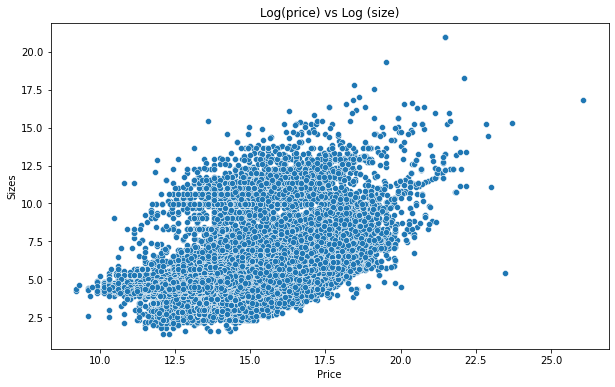

In [65]:
plt.figure(figsize=(10,6))
plt.title("Log(price) vs Log (size)")

sns.scatterplot(x= np.log(data["prices"]), y= np.log(data["sizes"]))

plt.xlabel("Price")
plt.ylabel("Sizes")

plt.show()

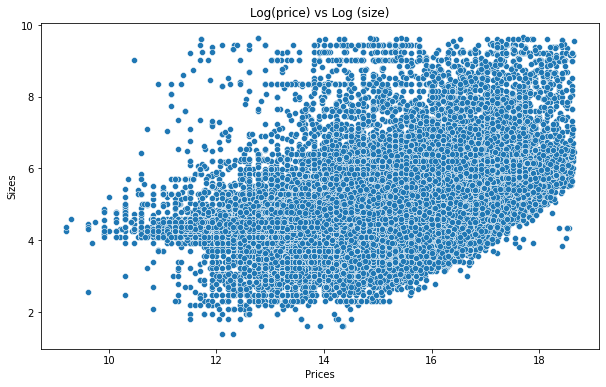

In [66]:
data_without_outliers = drop_outliers_for_numerical(data, "prices")
data_without_outliers = drop_outliers_for_numerical(data_without_outliers, "sizes")

plt.figure(figsize=(10,6))
plt.title("Log(price) vs Log (size)")
sns.scatterplot(x= np.log(data_without_outliers["prices"]), y= np.log(data_without_outliers["sizes"]))

plt.xlabel("Prices")
plt.ylabel("Sizes")

plt.show()

In [67]:
data_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277356 entries, 0 to 277355
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   locations    277356 non-null  object 
 1   prices       277356 non-null  float64
 2   Price_per_m  277356 non-null  float64
 3   sizes        277356 non-null  int32  
 4   rooms        277356 non-null  int32  
 5   bathrooms    277356 non-null  int32  
 6   finishes     277356 non-null  object 
 7   views        277356 non-null  object 
 8   floors       277356 non-null  int32  
 9   years        277356 non-null  float64
 10  payments     277356 non-null  object 
dtypes: float64(3), int32(4), object(4)
memory usage: 19.0+ MB


###### Rooms

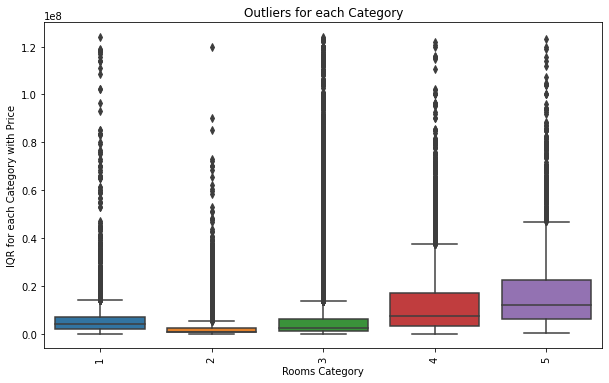

In [68]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Outliers for each Category")
sns.boxplot(x = data_without_outliers["rooms"], y= data_without_outliers["prices"])

plt.xlabel("Rooms Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

In [69]:
data_without_outliers = data_without_outliers.groupby("rooms").apply(drop_outliers_for_categorical)
data_without_outliers.reset_index(drop= True, inplace= True)
data_without_outliers

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo,5897000.0,78626.0,75,1,1,Semi Finished,Main Street,3,2027.0,Cash or Installments
1,Greater Cairo,5718000.0,76240.0,75,1,1,Semi Finished,Main Street,4,2027.0,Cash or Installments
2,Greater Cairo,19100000.0,70740.0,270,1,1,Without Finish,Main Street,0,2029.0,Cash or Installments
3,Greater Cairo,5172000.0,61571.0,84,1,1,Without Finish,Main Street,0,2028.0,Cash or Installments
4,Greater Cairo,4977000.0,58552.0,85,1,1,Without Finish,Main Street,2,2028.0,Cash or Installments
...,...,...,...,...,...,...,...,...,...,...,...
277209,Greater Cairo,12500000.0,43402.0,288,5,4,Super Lux,Main Street,1,2020.0,Cash
277210,Alexandria,5500000.0,13750.0,400,5,5,Super Lux,Other,1,2015.0,Cash
277211,Greater Cairo,5000000.0,17857.0,280,5,3,Super Lux,Main Street,0,2020.0,Cash
277212,Alexandria,2500000.0,3846.0,650,5,3,Super Lux,Other,9,2007.0,Cash


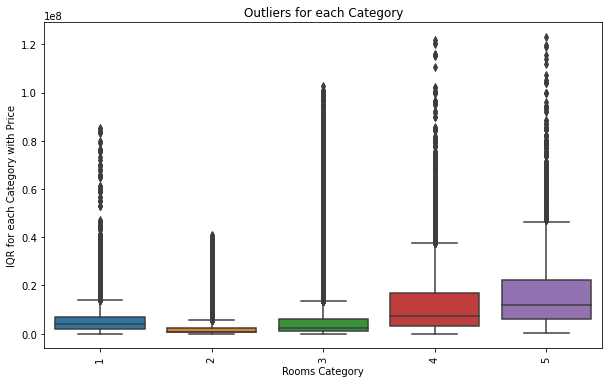

In [70]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Outliers for each Category")
sns.boxplot(x = data_without_outliers["rooms"], y= data_without_outliers["prices"])

plt.xlabel("Rooms Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

###### Bathrooms

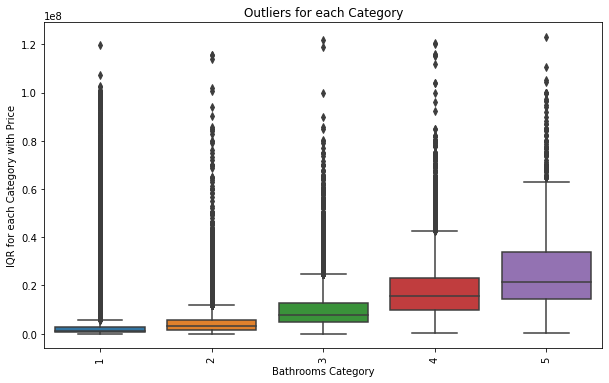

In [71]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Outliers for each Category")
sns.boxplot(x = data_without_outliers["bathrooms"], y= data_without_outliers["prices"])

plt.xlabel("Bathrooms Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

In [72]:
data_without_outliers = data_without_outliers.groupby("bathrooms").apply(drop_outliers_for_categorical)
data_without_outliers.reset_index(drop= True, inplace= True)
data_without_outliers

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo,5897000.0,78626.0,75,1,1,Semi Finished,Main Street,3,2027.0,Cash or Installments
1,Greater Cairo,5718000.0,76240.0,75,1,1,Semi Finished,Main Street,4,2027.0,Cash or Installments
2,Greater Cairo,19100000.0,70740.0,270,1,1,Without Finish,Main Street,0,2029.0,Cash or Installments
3,Greater Cairo,5172000.0,61571.0,84,1,1,Without Finish,Main Street,0,2028.0,Cash or Installments
4,Greater Cairo,4977000.0,58552.0,85,1,1,Without Finish,Main Street,2,2028.0,Cash or Installments
...,...,...,...,...,...,...,...,...,...,...,...
277114,Alexandria,15000000.0,58139.0,258,5,5,Semi Finished,Garden,1,2019.0,Cash
277115,Greater Cairo,33000000.0,83544.0,395,5,5,Super Lux,Other,1,2021.0,Cash
277116,Alexandria,9000000.0,22500.0,400,5,5,Extra Super Lux,Other,1,2021.0,Cash
277117,Alexandria,4000000.0,11428.0,350,5,5,Extra Super Lux,Garden,1,2023.0,Cash


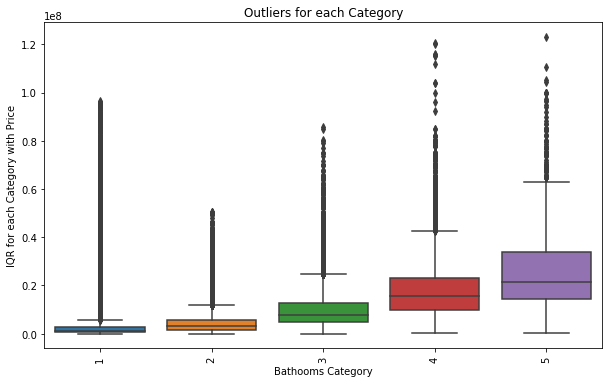

In [73]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Outliers for each Category")
sns.boxplot(x = data_without_outliers["bathrooms"], y= data_without_outliers["prices"])

plt.xlabel("Bathooms Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

###### Floors

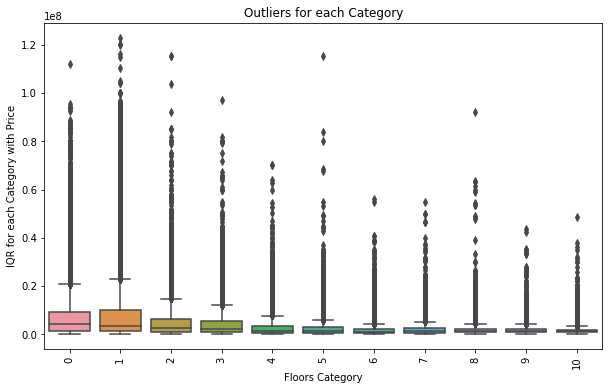

In [74]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Outliers for each Category")
sns.boxplot(x = data_without_outliers["floors"], y= data_without_outliers["prices"])

plt.xlabel("Floors Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

In [75]:
data_without_outliers = data_without_outliers.groupby("floors").apply(drop_outliers_for_categorical)
data_without_outliers.reset_index(drop= True, inplace= True)
data_without_outliers

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments
0,Greater Cairo,19100000.0,70740.0,270,1,1,Without Finish,Main Street,0,2029.0,Cash or Installments
1,Greater Cairo,5172000.0,61571.0,84,1,1,Without Finish,Main Street,0,2028.0,Cash or Installments
2,Greater Cairo,4504500.0,49500.0,91,1,1,Semi Finished,Garden,0,2027.0,Cash or Installments
3,Greater Cairo,11736515.0,138076.0,85,1,1,Semi Finished,Garden,0,2026.0,Cash or Installments
4,other,5250000.0,95454.0,55,1,1,Extra Super Lux,Main Street,0,2025.0,Cash or Installments
...,...,...,...,...,...,...,...,...,...,...,...
276998,Alexandria,15000000.0,12000.0,1250,5,5,Lux,Main Street,10,1999.0,Cash
276999,Greater Cairo,9000000.0,18000.0,500,5,5,Super Lux,Other,10,2021.0,Cash
277000,Greater Cairo,7500000.0,17857.0,420,5,5,Lux,Main Street,10,2000.0,Cash
277001,Greater Cairo,30000000.0,82191.0,365,5,5,Extra Super Lux,Other,10,2018.0,Cash or Installments


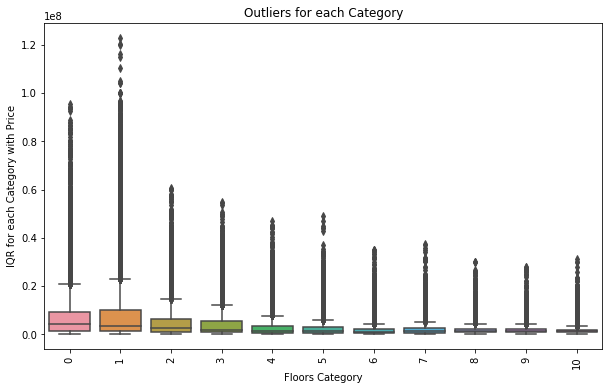

In [76]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Outliers for each Category")
sns.boxplot(x = data_without_outliers["floors"], y= data_without_outliers["prices"])

plt.xlabel("Floors Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

###### Years

In [77]:
data_without_outliers["property_age"] = 2024 - data_without_outliers["years"]
data_without_outliers

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments,property_age
0,Greater Cairo,19100000.0,70740.0,270,1,1,Without Finish,Main Street,0,2029.0,Cash or Installments,-5.0
1,Greater Cairo,5172000.0,61571.0,84,1,1,Without Finish,Main Street,0,2028.0,Cash or Installments,-4.0
2,Greater Cairo,4504500.0,49500.0,91,1,1,Semi Finished,Garden,0,2027.0,Cash or Installments,-3.0
3,Greater Cairo,11736515.0,138076.0,85,1,1,Semi Finished,Garden,0,2026.0,Cash or Installments,-2.0
4,other,5250000.0,95454.0,55,1,1,Extra Super Lux,Main Street,0,2025.0,Cash or Installments,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
276998,Alexandria,15000000.0,12000.0,1250,5,5,Lux,Main Street,10,1999.0,Cash,25.0
276999,Greater Cairo,9000000.0,18000.0,500,5,5,Super Lux,Other,10,2021.0,Cash,3.0
277000,Greater Cairo,7500000.0,17857.0,420,5,5,Lux,Main Street,10,2000.0,Cash,24.0
277001,Greater Cairo,30000000.0,82191.0,365,5,5,Extra Super Lux,Other,10,2018.0,Cash or Installments,6.0


In [78]:
data_without_outliers.drop(data_without_outliers[data_without_outliers["years"] > 2035].index, inplace= True)
data_without_outliers.reset_index(drop= True, inplace= True)

# Exploratory Data Analysis

- before we start we should convert our prices to uninflated prices (Adjusted_Price).

- My inflation rates data is from 2010 to 2050 so we will work on data in this period.



In [79]:
inflation = pd.DataFrame()
inflation_rate = pd.read_excel("Inflations Historical.xlsx", header=1)
inflation_rate = inflation_rate.iloc[0:241:]
inflation_rate

,Date,Headline (y/y),Core (y/y),Regulated Items (y/y),Fruits and Vegetables (y/y)
0,Jan 2025,23.950%,22.590%,29.890%,20.890%
1,Dec 2024,24.060%,23.220%,31.250%,11.830%
2,Nov 2024,25.540%,23.710%,30.750%,30.000%
3,Oct 2024,26.531%,24.404%,31.810%,34.190%
4,Sep 2024,26.397%,24.966%,30.242%,30.290%
...,...,...,...,...,...
236,May 2005,5.081%,4.103%,7.638%,5.672%
237,Apr 2005,4.604%,4.530%,7.546%,-2.573%
238,Mar 2005,5.527%,5.995%,7.637%,-3.476%
239,Feb 2005,6.729%,6.144%,10.852%,0.014%


In [80]:
inflation["date_inflation"] = inflation_rate["Date"].str.split(" ", expand= True)[1]
inflation["headline_inflation"] = inflation_rate["Headline (y/y)"].str.split("%", expand= True)[0]
inflation["core_inflation"] = inflation_rate["Core (y/y)"].str.split("%", expand= True)[0]
inflation["regulated_inflation"] = inflation_rate["Regulated Items (y/y)"].str.split("%", expand= True)[0]
inflation["f_v_inflation"] = inflation_rate["Fruits and Vegetables (y/y)"].str.split("%", expand= True)[0]



inflation

,date_inflation,headline_inflation,core_inflation,regulated_inflation,f_v_inflation
0,2025,23.950,22.590,29.890,20.890
1,2024,24.060,23.220,31.250,11.830
2,2024,25.540,23.710,30.750,30.000
3,2024,26.531,24.404,31.810,34.190
4,2024,26.397,24.966,30.242,30.290
...,...,...,...,...,...
236,2005,5.081,4.103,7.638,5.672
237,2005,4.604,4.530,7.546,-2.573
238,2005,5.527,5.995,7.637,-3.476
239,2005,6.729,6.144,10.852,0.014


In [81]:
inflation.iloc[:,0] = inflation.iloc[:,0].astype(int)
inflation.iloc[:,1] = inflation.iloc[:,1].astype(float)
inflation.iloc[:,2] = inflation.iloc[:,2].astype(float)
inflation.iloc[:,3] = inflation.iloc[:,3].astype(float)
inflation.iloc[:,4] = inflation.iloc[:,4].astype(float)

inflation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_inflation       241 non-null    int32  
 1   headline_inflation   241 non-null    float64
 2   core_inflation       241 non-null    float64
 3   regulated_inflation  241 non-null    float64
 4   f_v_inflation        241 non-null    float64
dtypes: float64(4), int32(1)
memory usage: 8.6 KB


In [82]:
cpi_by_year = inflation.groupby("date_inflation")["core_inflation"].mean()
cpi_by_year = pd.DataFrame(cpi_by_year)
cpi_by_year

,core_inflation
date_inflation,
2005,4.022500
2006,6.196583
2007,8.013917
2008,18.931833
2009,8.958508
2010,7.570833
2011,8.302925
2012,6.186917
2013,9.015750


In [83]:
cpi = [1]
for i in range(1, len(cpi_by_year)):
    cpi.append(cpi[i-1] * (1 + cpi_by_year.loc[2004 + i, 'core_inflation']/100))
cpi_by_year['CPI'] = cpi
cpi_by_year

,core_inflation,CPI
date_inflation,,
2005,4.022500,1.000000
2006,6.196583,1.040225
2007,8.013917,1.104683
2008,18.931833,1.193212
2009,8.958508,1.419109
2010,7.570833,1.546240
2011,8.302925,1.663303
2012,6.186917,1.801406
2013,9.015750,1.912857


In [84]:
data_inflated = data_without_outliers.merge(cpi_by_year, how= "left", left_on="years", right_index= True)
data_inflated = data_inflated[(data_inflated["years"] >= 2005)]
data_inflated

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments,property_age,core_inflation,CPI
0,Greater Cairo,19100000.0,70740.0,270,1,1,Without Finish,Main Street,0,2029.0,Cash or Installments,-5.0,NaN,NaN
1,Greater Cairo,5172000.0,61571.0,84,1,1,Without Finish,Main Street,0,2028.0,Cash or Installments,-4.0,NaN,NaN
2,Greater Cairo,4504500.0,49500.0,91,1,1,Semi Finished,Garden,0,2027.0,Cash or Installments,-3.0,NaN,NaN
3,Greater Cairo,11736515.0,138076.0,85,1,1,Semi Finished,Garden,0,2026.0,Cash or Installments,-2.0,NaN,NaN
4,other,5250000.0,95454.0,55,1,1,Extra Super Lux,Main Street,0,2025.0,Cash or Installments,-1.0,22.590000,9.108303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276674,Alexandria,23316800.0,61360.0,380,4,5,Extra Super Lux,Garden,10,2027.0,Installments,-3.0,NaN,NaN
276675,Greater Cairo,8500000.0,36956.0,230,4,5,Super Lux,Main Street,10,2016.0,Cash,8.0,13.296167,2.436150
276676,Alexandria,17000000.0,51515.0,330,4,5,Super Lux,Sea View,10,2020.0,Cash,4.0,2.336500,4.210838
276679,Greater Cairo,9000000.0,18000.0,500,5,5,Super Lux,Other,10,2021.0,Cash,3.0,4.372250,4.309224


In [85]:
cpi_2024_base = cpi_by_year[cpi_by_year.index == 2024]["CPI"].values[0]
cpi_2025= cpi_by_year[cpi_by_year.index == 2025]["CPI"].values[0]

data_inflated.loc[data_inflated["years"] >= 2025, "CPI"] = cpi_2025 

data_inflated['Adjusted_Price'] = data_inflated['prices'] * (cpi_2024_base / data_inflated['CPI'])
data_inflated.reset_index(drop= True, inplace= True)
data_inflated

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments,property_age,core_inflation,CPI,Adjusted_Price
0,Greater Cairo,19100000.0,70740.0,270,1,1,Without Finish,Main Street,0,2029.0,Cash or Installments,-5.0,NaN,9.108303,1.498843e+07
1,Greater Cairo,5172000.0,61571.0,84,1,1,Without Finish,Main Street,0,2028.0,Cash or Installments,-4.0,NaN,9.108303,4.058648e+06
2,Greater Cairo,4504500.0,49500.0,91,1,1,Semi Finished,Garden,0,2027.0,Cash or Installments,-3.0,NaN,9.108303,3.534838e+06
3,Greater Cairo,11736515.0,138076.0,85,1,1,Semi Finished,Garden,0,2026.0,Cash or Installments,-2.0,NaN,9.108303,9.210052e+06
4,other,5250000.0,95454.0,55,1,1,Extra Super Lux,Main Street,0,2025.0,Cash or Installments,-1.0,22.590000,9.108303,4.119858e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259813,Alexandria,23316800.0,61360.0,380,4,5,Extra Super Lux,Garden,10,2027.0,Installments,-3.0,NaN,9.108303,1.829750e+07
259814,Greater Cairo,8500000.0,36956.0,230,4,5,Super Lux,Main Street,10,2016.0,Cash,8.0,13.296167,2.436150,2.493878e+07
259815,Alexandria,17000000.0,51515.0,330,4,5,Super Lux,Sea View,10,2020.0,Cash,4.0,2.336500,4.210838,2.885631e+07
259816,Greater Cairo,9000000.0,18000.0,500,5,5,Super Lux,Other,10,2021.0,Cash,3.0,4.372250,4.309224,1.492808e+07


###### Years

- check Prices decades

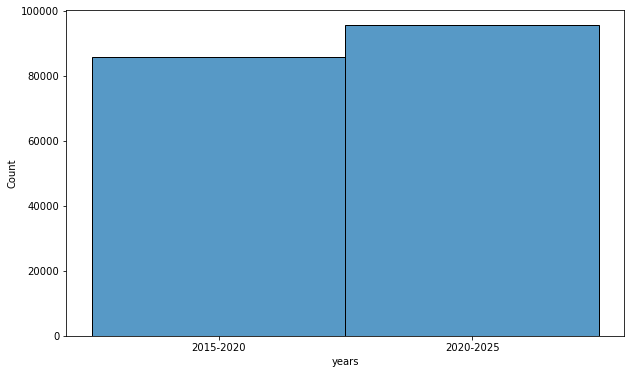

In [86]:
bins = [2015, 2020, 2025]
labels = ["2015-2020", "2020-2025"] 
decade = pd.cut(data_inflated["years"], bins=bins, labels= labels)

plt.figure(figsize=(10,6))
sns.histplot(decade)
plt.show()

- let's check the total prices in decade 2010-2020 and 2020-2030 and check if there is any difference between them

In [87]:
decade = pd.DataFrame(decade)
decade = decade.rename(columns={"years" : "decade"})
data_inflated = pd.concat([data_inflated, decade], axis=1)
data_inflated

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments,property_age,core_inflation,CPI,Adjusted_Price,decade
0,Greater Cairo,19100000.0,70740.0,270,1,1,Without Finish,Main Street,0,2029.0,Cash or Installments,-5.0,NaN,9.108303,1.498843e+07,NaN
1,Greater Cairo,5172000.0,61571.0,84,1,1,Without Finish,Main Street,0,2028.0,Cash or Installments,-4.0,NaN,9.108303,4.058648e+06,NaN
2,Greater Cairo,4504500.0,49500.0,91,1,1,Semi Finished,Garden,0,2027.0,Cash or Installments,-3.0,NaN,9.108303,3.534838e+06,NaN
3,Greater Cairo,11736515.0,138076.0,85,1,1,Semi Finished,Garden,0,2026.0,Cash or Installments,-2.0,NaN,9.108303,9.210052e+06,NaN
4,other,5250000.0,95454.0,55,1,1,Extra Super Lux,Main Street,0,2025.0,Cash or Installments,-1.0,22.590000,9.108303,4.119858e+06,2020-2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259813,Alexandria,23316800.0,61360.0,380,4,5,Extra Super Lux,Garden,10,2027.0,Installments,-3.0,NaN,9.108303,1.829750e+07,NaN
259814,Greater Cairo,8500000.0,36956.0,230,4,5,Super Lux,Main Street,10,2016.0,Cash,8.0,13.296167,2.436150,2.493878e+07,2015-2020
259815,Alexandria,17000000.0,51515.0,330,4,5,Super Lux,Sea View,10,2020.0,Cash,4.0,2.336500,4.210838,2.885631e+07,2015-2020
259816,Greater Cairo,9000000.0,18000.0,500,5,5,Super Lux,Other,10,2021.0,Cash,3.0,4.372250,4.309224,1.492808e+07,2020-2025


In [88]:
temp = data_inflated[~(data_inflated["decade"].isna())]

In [89]:
temp["profit"] = data_inflated["prices"] * .02
temp["adjusted_profit"] = data_inflated["Adjusted_Price"] * .02
temp

C:\Users\Mourad\AppData\Local\Temp/ipykernel_17324/3396788634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["profit"] = data_inflated["prices"] * .02
C:\Users\Mourad\AppData\Local\Temp/ipykernel_17324/3396788634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["adjusted_profit"] = data_inflated["Adjusted_Price"] * .02


,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments,property_age,core_inflation,CPI,Adjusted_Price,decade,profit,adjusted_profit
4,other,5250000.0,95454.0,55,1,1,Extra Super Lux,Main Street,0,2025.0,Cash or Installments,-1.0,22.590000,9.108303,4.119858e+06,2020-2025,105000.00,8.239716e+04
5,other,1100000.0,18333.0,60,1,1,Without Finish,Side Street,0,2024.0,Cash,0.0,27.431583,7.147603,1.100000e+06,2020-2025,22000.00,2.200000e+04
6,Greater Cairo,3200000.0,50000.0,64,1,1,Semi Finished,Garden,0,2025.0,Cash,-1.0,22.590000,9.108303,2.511151e+06,2020-2025,64000.00,5.022303e+04
9,other,6572000.0,90027.0,73,1,1,Extra Super Lux,Sea View,0,2025.0,Cash or Installments,-1.0,22.590000,9.108303,5.157277e+06,2020-2025,131440.00,1.031455e+05
10,Greater Cairo,5477700.0,58900.0,93,1,1,Semi Finished,Main Street,0,2022.0,Cash or Installments,2.0,14.891917,4.497634,8.705115e+06,2020-2025,109554.00,1.741023e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259811,Greater Cairo,19383376.0,80096.0,242,4,5,Super Lux,Other,10,2025.0,Installments,-1.0,22.590000,9.108303,1.521081e+07,2020-2025,387667.52,3.042162e+05
259814,Greater Cairo,8500000.0,36956.0,230,4,5,Super Lux,Main Street,10,2016.0,Cash,8.0,13.296167,2.436150,2.493878e+07,2015-2020,170000.00,4.987756e+05
259815,Alexandria,17000000.0,51515.0,330,4,5,Super Lux,Sea View,10,2020.0,Cash,4.0,2.336500,4.210838,2.885631e+07,2015-2020,340000.00,5.771262e+05
259816,Greater Cairo,9000000.0,18000.0,500,5,5,Super Lux,Other,10,2021.0,Cash,3.0,4.372250,4.309224,1.492808e+07,2020-2025,180000.00,2.985615e+05


C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


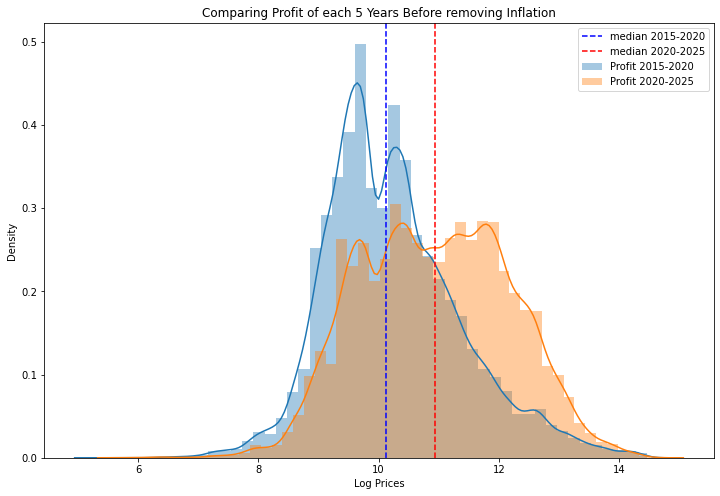

In [134]:
plt.figure(figsize=(12, 8))
plt.title("Comparing Profit of each 5 Years Before removing Inflation")

sns.distplot(np.log(temp[temp["decade"] == "2015-2020"]["profit"]), label= "Profit 2015-2020")
sns.distplot(np.log(temp[temp["decade"] == "2020-2025"]["profit"]), label="Profit 2020-2025")

plt.axvline(np.median(np.log(temp[temp["decade"] == "2015-2020"]["profit"])),  0, label= "median 2015-2020", linestyle = "--", color = "b")
plt.axvline(np.median(np.log(temp[temp["decade"] == "2020-2025"]["profit"])),  0, label= "median 2020-2025", linestyle = "--", color = "r")

plt.xlabel("Log Prices")
plt.legend()
plt.show()

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


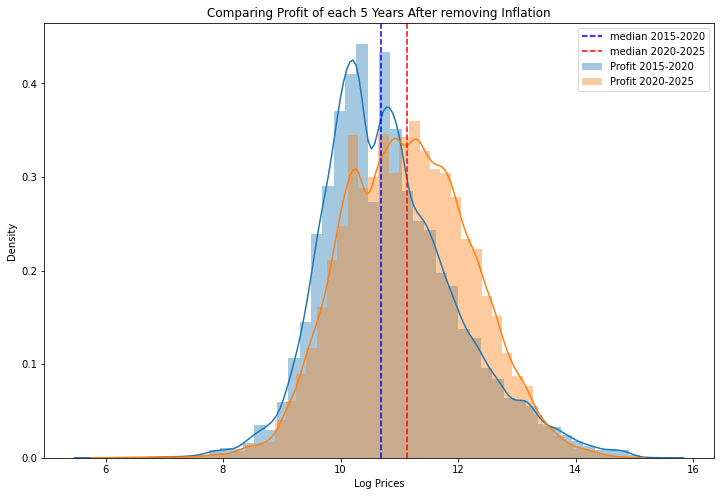

In [135]:
plt.figure(figsize=(12, 8))
plt.title("Comparing Profit of each 5 Years After removing Inflation")


sns.distplot(np.log(temp[temp["decade"] == "2015-2020"]["adjusted_profit"]), label= "Profit 2015-2020")
sns.distplot(np.log(temp[temp["decade"] == "2020-2025"]["adjusted_profit"]), label="Profit 2020-2025")

plt.axvline(np.median(np.log(temp[temp["decade"] == "2015-2020"]["adjusted_profit"])),  0, label= "median 2015-2020", linestyle = "--", color = "b")
plt.axvline(np.median(np.log(temp[temp["decade"] == "2020-2025"]["adjusted_profit"])),  0, label= "median 2020-2025", linestyle = "--", color = "r")

plt.xlabel("Log Prices")
plt.legend()
plt.show()

###### Locations

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


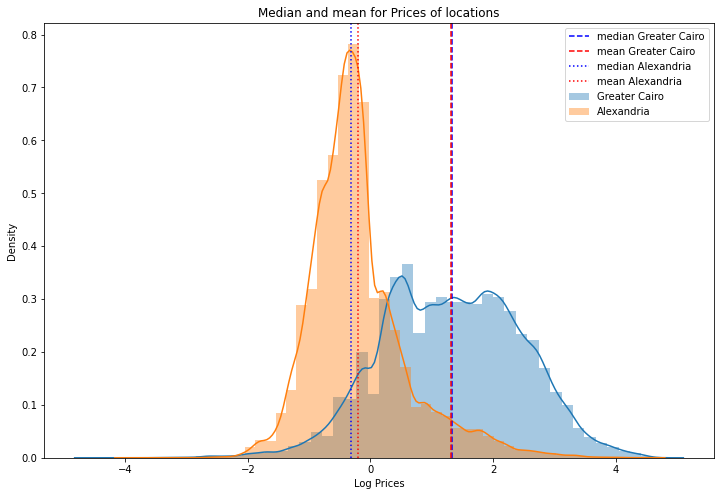

In [92]:
plt.figure(figsize=(12, 8))

for location in data_inflated['locations'].value_counts().index[:2].values:
    sns.distplot(np.log(data_inflated[data_inflated['locations'] == location]['prices'] / 1000000), kde=True, label=f'{location}')
    plt.title("Median and mean for Prices of locations")
    plt.xlabel("Log Prices")
    
plt.axvline(np.median(np.log(data_inflated[data_inflated['locations'] == "Greater Cairo"]['prices'] / 1000000)), 0, label= "median Greater Cairo", linestyle = "--", color = "b")
plt.axvline(np.mean(np.log(data_inflated[data_inflated['locations'] == "Greater Cairo"]['prices'] / 1000000)), 0, label= "mean Greater Cairo", linestyle = "--", color = "r") 
    
plt.axvline(np.median(np.log(data_inflated[data_inflated['locations'] == "Alexandria"]['prices'] / 1000000)), 0, label= "median Alexandria", linestyle = "dotted", color = "b")
plt.axvline(np.mean(np.log(data_inflated[data_inflated['locations'] == "Alexandria"]['prices'] / 1000000)), 0, label= "mean Alexandria", linestyle = "dotted", color = "r") 
plt.legend()
       

In [93]:
sample1_without_inflation = data_inflated[data_inflated['locations'] == "Greater Cairo"]['prices']
sample2_without_inflation = data_inflated[data_inflated['locations'] == "Alexandria"]['prices']

hypothesis_test(sample1_without_inflation, sample2_without_inflation, .05)

'P-value = 0.0 so we will reject the Null Hypothesis. Result ==> there are difference between means'

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


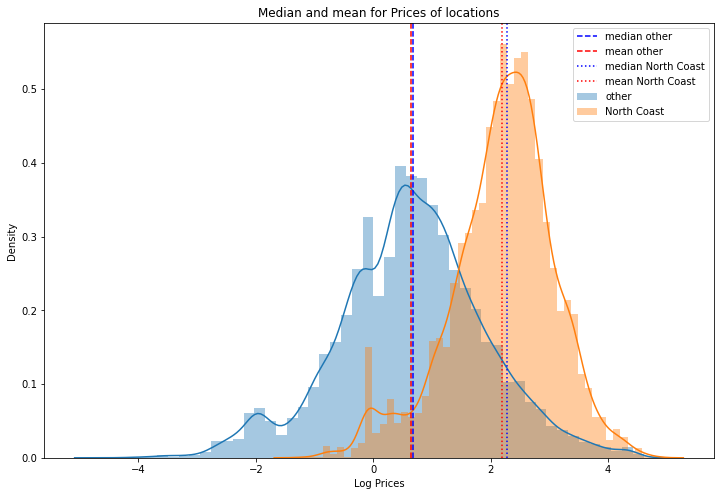

In [94]:
plt.figure(figsize=(12, 8))

for location in data_inflated['locations'].value_counts().index[2:].values:
    sns.distplot(np.log(data_inflated[data_inflated['locations'] == location]['prices'] / 1000000), kde=True, label=f'{location}')
    plt.title("Median and mean for Prices of locations")
    plt.xlabel("Log Prices")
    
plt.axvline(np.median(np.log(data_inflated[data_inflated['locations'] == "other"]['prices'] / 1000000)), 0, label= "median other", linestyle = "--", color = "b")
plt.axvline(np.mean(np.log(data_inflated[data_inflated['locations'] == "other"]['prices'] / 1000000)), 0, label= "mean other", linestyle = "--", color = "r") 
    
plt.axvline(np.median(np.log(data_inflated[data_inflated['locations'] == "North Coast"]['prices'] / 1000000)), 0, label= "median North Coast", linestyle = "dotted", color = "b")
plt.axvline(np.mean(np.log(data_inflated[data_inflated['locations'] == "North Coast"]['prices'] / 1000000)), 0, label= "mean North Coast", linestyle = "dotted", color = "r") 
plt.legend()
    

- Check equality of means using hypothesis test but using ANOVA for multiple groups.

In [95]:
sample1 = data_inflated[data_inflated['locations'] == "Greater Cairo"]['prices']
sample2 = data_inflated[data_inflated['locations'] == "Alexandria"]['prices']   
sample3 = data_inflated[data_inflated['locations'] == "North Coast"]['prices']
sample4 = data_inflated[data_inflated['locations'] == "other"]['prices']   

Multi_hypothesis_test(sample1, sample2, sample3, sample4)

'P-value = 0.0 so we will reject the Null Hypothesis. Result ==> there are difference between means'

""" North Coast >> Greater Cairo >> other >> Alexandria

###### Sizes

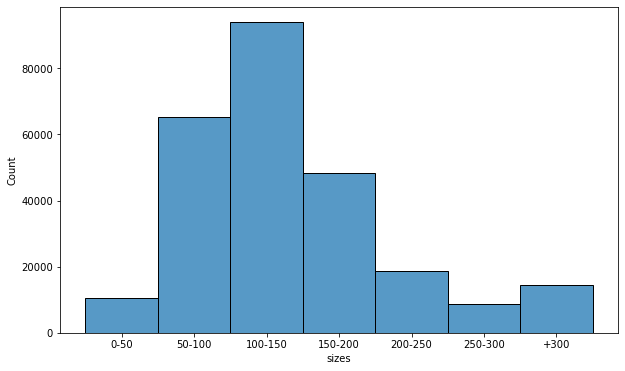

In [96]:
bins = [0, 50, 100, 150, 200, 250, 300,9999999]
labels = ["0-50", "50-100", "100-150", "150-200", "200-250", "250-300", "+300" ] 
size_range = pd.cut(data_inflated["sizes"], bins=bins, labels= labels)

plt.figure(figsize=(10,6))
sns.histplot(size_range)
plt.show()

- Most Properties Sizes from 100-150

In [97]:
size_range = pd.DataFrame(size_range)
size_range = size_range.rename(columns={"sizes" : "size_range"})
data_inflated = pd.concat([data_inflated, size_range], axis=1)
data_inflated

,locations,prices,Price_per_m,sizes,rooms,bathrooms,finishes,views,floors,years,payments,property_age,core_inflation,CPI,Adjusted_Price,decade,size_range
0,Greater Cairo,19100000.0,70740.0,270,1,1,Without Finish,Main Street,0,2029.0,Cash or Installments,-5.0,NaN,9.108303,1.498843e+07,NaN,250-300
1,Greater Cairo,5172000.0,61571.0,84,1,1,Without Finish,Main Street,0,2028.0,Cash or Installments,-4.0,NaN,9.108303,4.058648e+06,NaN,50-100
2,Greater Cairo,4504500.0,49500.0,91,1,1,Semi Finished,Garden,0,2027.0,Cash or Installments,-3.0,NaN,9.108303,3.534838e+06,NaN,50-100
3,Greater Cairo,11736515.0,138076.0,85,1,1,Semi Finished,Garden,0,2026.0,Cash or Installments,-2.0,NaN,9.108303,9.210052e+06,NaN,50-100
4,other,5250000.0,95454.0,55,1,1,Extra Super Lux,Main Street,0,2025.0,Cash or Installments,-1.0,22.590000,9.108303,4.119858e+06,2020-2025,50-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259813,Alexandria,23316800.0,61360.0,380,4,5,Extra Super Lux,Garden,10,2027.0,Installments,-3.0,NaN,9.108303,1.829750e+07,NaN,+300
259814,Greater Cairo,8500000.0,36956.0,230,4,5,Super Lux,Main Street,10,2016.0,Cash,8.0,13.296167,2.436150,2.493878e+07,2015-2020,200-250
259815,Alexandria,17000000.0,51515.0,330,4,5,Super Lux,Sea View,10,2020.0,Cash,4.0,2.336500,4.210838,2.885631e+07,2015-2020,+300
259816,Greater Cairo,9000000.0,18000.0,500,5,5,Super Lux,Other,10,2021.0,Cash,3.0,4.372250,4.309224,1.492808e+07,2020-2025,+300


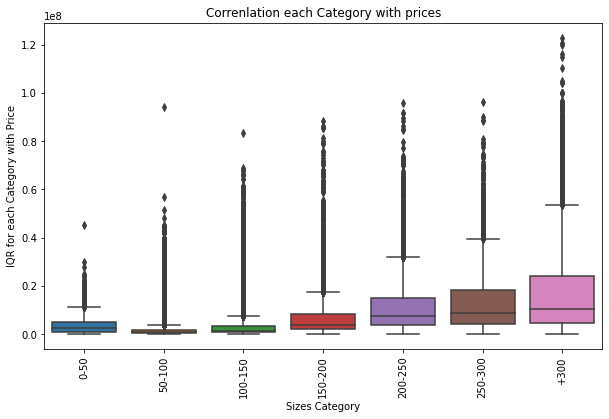

In [98]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Correnlation each Category with prices")
sns.boxplot(x = data_inflated["size_range"], y= data_inflated["prices"])

plt.xlabel("Sizes Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

###### Rooms & Bathrooms

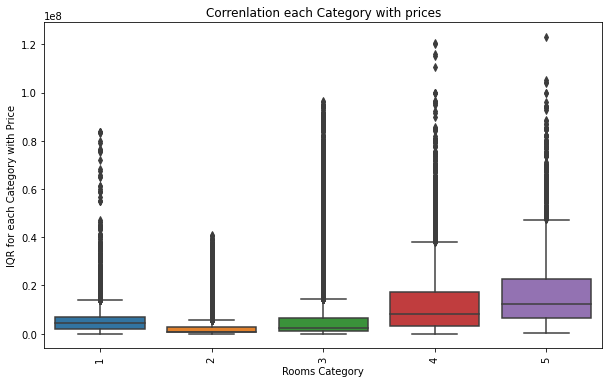

In [99]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Correnlation each Category with prices")
sns.boxplot(x = data_inflated["rooms"], y= data_inflated["prices"])

plt.xlabel("Rooms Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

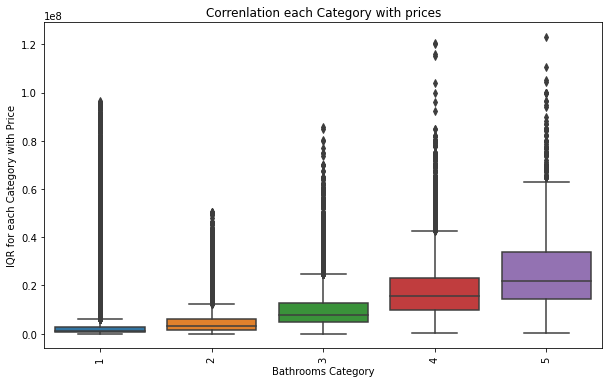

In [100]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Correnlation each Category with prices")
sns.boxplot(x = data_inflated["bathrooms"], y= data_inflated["prices"])

plt.xlabel("Bathrooms Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

- The more rooms and bathrooms, the higher the price. 


###### Finish Type

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

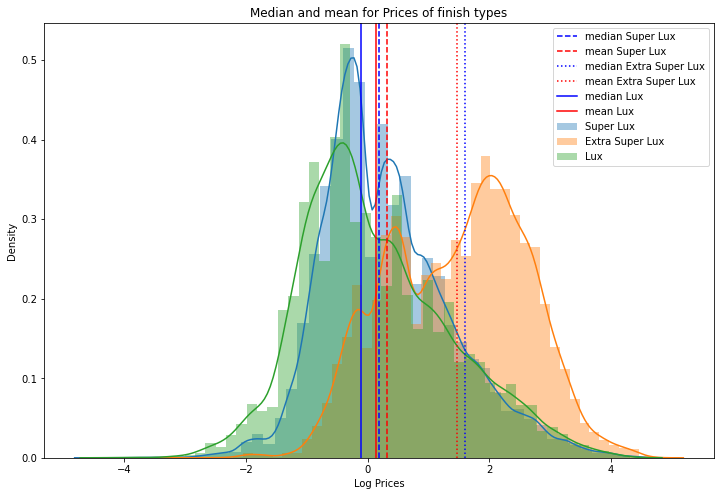

In [101]:
plt.figure(figsize=(12, 8))

for location in data_inflated['finishes'].value_counts().index[[0,1,4]].values:
    sns.distplot(np.log(data_inflated[data_inflated['finishes'] == location]['prices'] / 1000000), kde=True, label=f'{location}')
    plt.title("Median and mean for Prices of finish types")
    plt.xlabel("Log Prices")
    
plt.axvline(np.median(np.log(data_inflated[data_inflated['finishes'] == "Super Lux"]['prices'] / 1000000)), 0, label= "median Super Lux", linestyle = "--", color = "b")
plt.axvline(np.mean(np.log(data_inflated[data_inflated['finishes'] == "Super Lux"]['prices'] / 1000000)), 0, label= "mean Super Lux", linestyle = "--", color = "r") 
    
plt.axvline(np.median(np.log(data_inflated[data_inflated['finishes'] == "Extra Super Lux"]['prices'] / 1000000)), 0, label= "median Extra Super Lux", linestyle = "dotted", color = "b")
plt.axvline(np.mean(np.log(data_inflated[data_inflated['finishes'] == "Extra Super Lux"]['prices'] / 1000000)), 0, label= "mean Extra Super Lux", linestyle = "dotted", color = "r") 

plt.axvline(np.median(np.log(data_inflated[data_inflated['finishes'] == "Lux"]['prices'] / 1000000)), 0, label= "median Lux", linestyle = "-", color = "b")
plt.axvline(np.mean(np.log(data_inflated[data_inflated['finishes'] == "Lux"]['prices'] / 1000000)), 0, label= "mean Lux", linestyle = "-", color = "r") 
plt.legend()
    

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


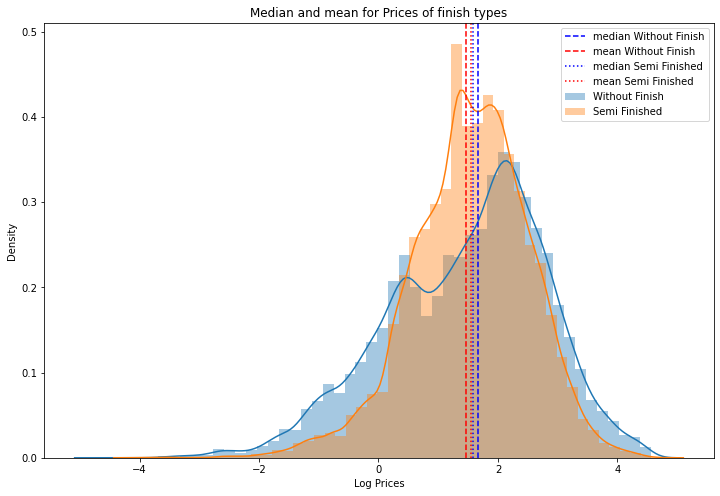

In [102]:
plt.figure(figsize=(12, 8))

for location in data_inflated['finishes'].value_counts().index[[2,3]].values:
    sns.distplot(np.log(data_inflated[data_inflated['finishes'] == location]['prices'] / 1000000), kde=True, label=f'{location}')
    plt.title("Median and mean for Prices of finish types")
    plt.xlabel("Log Prices")
    
plt.axvline(np.median(np.log(data_inflated[data_inflated['finishes'] == "Without Finish"]['prices'] / 1000000)), 0, label= "median Without Finish", linestyle = "--", color = "b")
plt.axvline(np.mean(np.log(data_inflated[data_inflated['finishes'] == "Without Finish"]['prices'] / 1000000)), 0, label= "mean Without Finish", linestyle = "--", color = "r") 
    
plt.axvline(np.median(np.log(data_inflated[data_inflated['finishes'] == "Semi Finished"]['prices'] / 1000000)), 0, label= "median Semi Finished", linestyle = "dotted", color = "b")
plt.axvline(np.mean(np.log(data_inflated[data_inflated['finishes'] == "Semi Finished"]['prices'] / 1000000)), 0, label= "mean Semi Finished", linestyle = "dotted", color = "r") 
plt.legend()
    

""" I can buy lux, Super Lux and Semi Finished property much cheaper than the Without Finish Property!!!!!. """

I mostly have a problem with the pricing of 'wihtout Finsih' real estate owners.

###### Views & Floors

In [103]:
data_inflated["floors"].value_counts()

1     77360
2     36668
3     30205
0     29212
4     24401
5     18245
6     12369
7      8819
8      8087
10     7391
9      7061
Name: floors, dtype: int64

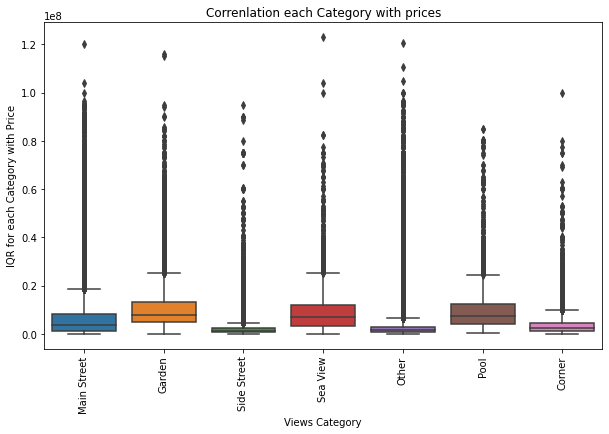

In [104]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Correnlation each Category with prices")
sns.boxplot(x = data_inflated["views"], y= data_inflated["prices"])

plt.xlabel("Views Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

Garden >> Pool >> Sea View >> Main Street

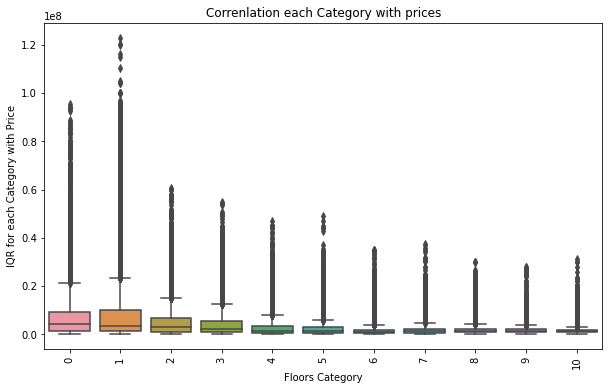

In [105]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Correnlation each Category with prices")
sns.boxplot(x = data_inflated["floors"], y= data_inflated["prices"])

plt.xlabel("Floors Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

""" More Floors, Lower prices. """

###### Payments

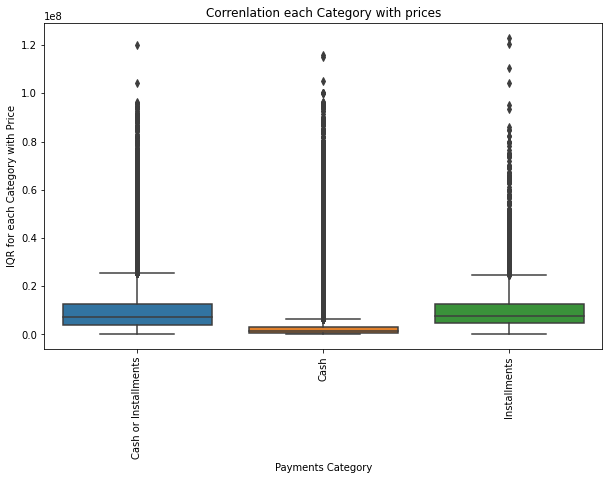

In [106]:
## Outliers for each Category
plt.figure(figsize=(10,6))
plt.title("Correnlation each Category with prices")
sns.boxplot(x = data_inflated["payments"], y= data_inflated["prices"])

plt.xlabel("Payments Category")
plt.xticks(rotation=90)
plt.ylabel("IQR for each Category with Price")

plt.show()

## Encoding

In [107]:
## Encoding Views and Payment Type Features
encoder = LabelEncoder()
data_inflated["views"] = encoder.fit_transform(data_inflated["views"])

## Encoding Payment Type Features
encoder = LabelEncoder()
data_inflated["payments"] = encoder.fit_transform(data_inflated["payments"])

## Encoding Payment Type Features
encoder = LabelEncoder()
data_inflated["decade"] = encoder.fit_transform(data_inflated["decade"])

In [108]:
# Encode other locations
data_inflated["locations"].replace("other", 1, inplace= True)
data_inflated["locations"].replace("Greater Cairo", 2, inplace= True)
data_inflated["locations"].replace("Alexandria", 3, inplace= True)
data_inflated["locations"].replace("North Coast", 4, inplace= True)

In [109]:
## Encoding Finish Type

data_inflated["finishes"].replace('Without Finish', 1, inplace= True)
data_inflated["finishes"].replace('Semi Finished', 2, inplace= True)
data_inflated["finishes"].replace('Lux', 3, inplace= True)
data_inflated["finishes"].replace('Super Lux', 4, inplace= True)
data_inflated["finishes"].replace('Extra Super Lux', 5, inplace= True)

In [110]:
categ_feat = data_inflated[["locations", "rooms", "bathrooms", "finishes", "views", "floors", "payments", "decade"]]
categ_feat

,locations,rooms,bathrooms,finishes,views,floors,payments,decade
0,2,1,1,1,2,0,1,2
1,2,1,1,1,2,0,1,2
2,2,1,1,2,1,0,1,2
3,2,1,1,2,1,0,1,2
4,1,1,1,5,2,0,1,1
...,...,...,...,...,...,...,...,...
259813,3,4,5,5,1,10,2,2
259814,2,4,5,4,2,10,0,0
259815,3,4,5,4,5,10,0,0
259816,2,5,5,4,3,10,0,1


In [111]:
num_feat = data_inflated[["Adjusted_Price", "sizes"]]
num_feat

,Adjusted_Price,sizes
0,1.498843e+07,270
1,4.058648e+06,84
2,3.534838e+06,91
3,9.210052e+06,85
4,4.119858e+06,55
...,...,...
259813,1.829750e+07,380
259814,2.493878e+07,230
259815,2.885631e+07,330
259816,1.492808e+07,500


# Assumptions For Linear Regression Model

- Linearity
- Homoscedasticity
- No or Little Multicollinearity

#### Check Correlation and Multicollinearity

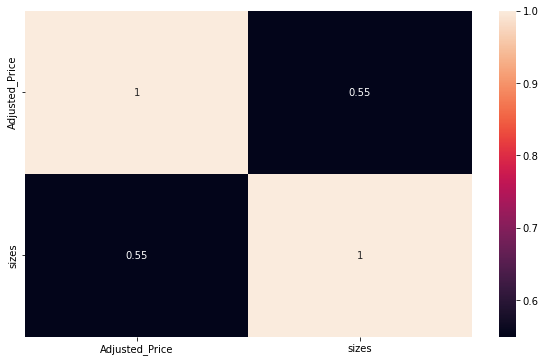

In [112]:
plt.figure(figsize= (10,6))
sns.heatmap(num_feat.corr(method="spearman"), annot= True)
plt.show()

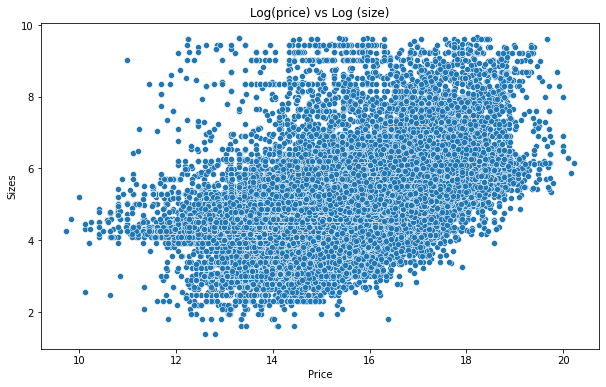

In [113]:
plt.figure(figsize=(10,6))
plt.title("Log(price) vs Log (size)")

sns.scatterplot(x= np.log(num_feat["Adjusted_Price"]), y= np.log(num_feat["sizes"]))

plt.xlabel("Price")
plt.ylabel("Sizes")

plt.show()

- More Sizes, More Prices.

Pairwise Mutual Information Matrix:


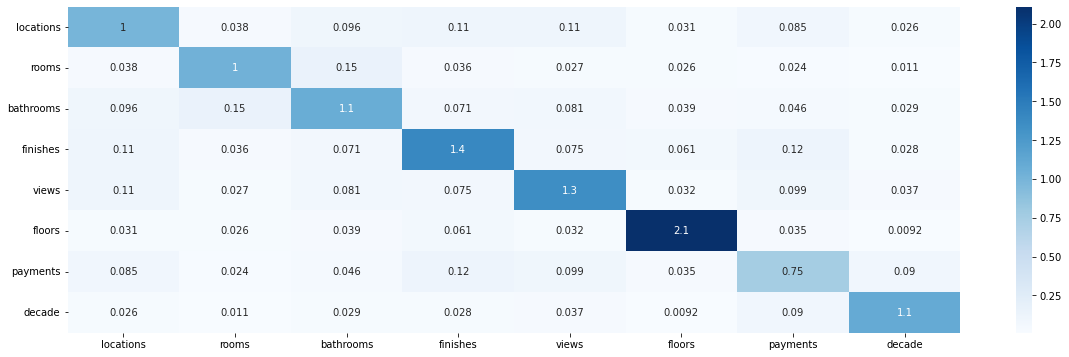

In [114]:
## Correlation for Categorical Features

n_features = len(categ_feat.columns)
mi_matrix = np.zeros((n_features, n_features))

## pairwise Mutual Information
for i in range(n_features):
    for j in range(n_features):
        mi_matrix[i, j] = mutual_info_score(categ_feat.iloc[:, i], categ_feat.iloc[:, j])

mi_df = pd.DataFrame(mi_matrix, 
                     index=categ_feat.columns, 
                     columns=categ_feat.columns)

print("Pairwise Mutual Information Matrix:")
plt.figure(figsize=(20,6))
sns.heatmap(mi_df, annot= True, cmap= "Blues")
plt.show()

C:\Users\Mourad\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\Mourad\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\Mourad\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Users\Mourad\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserW

Pairwise Mutual Information Matrix with Target:


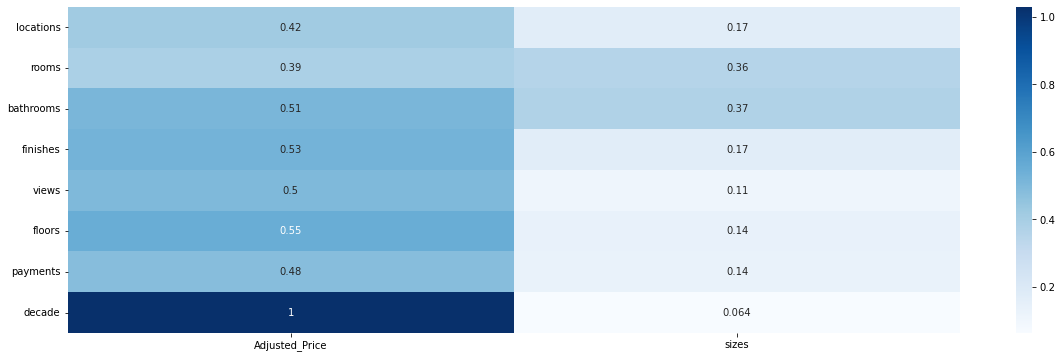

In [115]:
## Correlation between Categorical Features and Numerical Features

n_features = len(categ_feat.columns)
mi_matrix = np.zeros((n_features, len(num_feat.columns)))

# Compute pairwise Mutual Information
for i in range(n_features):
    for j in range(len(num_feat.columns)):
        mi_matrix[i, j] = mutual_info_score(categ_feat.iloc[:, i], num_feat.iloc[:, j])

# Convert to DataFrame for readability
mi_df = pd.DataFrame(mi_matrix, 
                     index=categ_feat.columns, 
                     columns=num_feat.columns)

print("Pairwise Mutual Information Matrix with Target:")
plt.figure(figsize=(20,6))
sns.heatmap(mi_df, annot= True, cmap= "Blues")
plt.show()

In [116]:
data_inflated.drop(columns="sizes", inplace= True, axis=1)
data_inflated.reset_index(drop= True, inplace= True)
data_inflated

,locations,prices,Price_per_m,rooms,bathrooms,finishes,views,floors,years,payments,property_age,core_inflation,CPI,Adjusted_Price,decade,size_range
0,2,19100000.0,70740.0,1,1,1,2,0,2029.0,1,-5.0,NaN,9.108303,1.498843e+07,2,250-300
1,2,5172000.0,61571.0,1,1,1,2,0,2028.0,1,-4.0,NaN,9.108303,4.058648e+06,2,50-100
2,2,4504500.0,49500.0,1,1,2,1,0,2027.0,1,-3.0,NaN,9.108303,3.534838e+06,2,50-100
3,2,11736515.0,138076.0,1,1,2,1,0,2026.0,1,-2.0,NaN,9.108303,9.210052e+06,2,50-100
4,1,5250000.0,95454.0,1,1,5,2,0,2025.0,1,-1.0,22.590000,9.108303,4.119858e+06,1,50-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259813,3,23316800.0,61360.0,4,5,5,1,10,2027.0,2,-3.0,NaN,9.108303,1.829750e+07,2,+300
259814,2,8500000.0,36956.0,4,5,4,2,10,2016.0,0,8.0,13.296167,2.436150,2.493878e+07,0,200-250
259815,3,17000000.0,51515.0,4,5,4,5,10,2020.0,0,4.0,2.336500,4.210838,2.885631e+07,0,+300
259816,2,9000000.0,18000.0,5,5,4,3,10,2021.0,0,3.0,4.372250,4.309224,1.492808e+07,1,+300


# Assumptions For Linear Regression Model

- Linearity
- Homoscedasticity
- No or Little Multicollinearity

###### Linearity

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


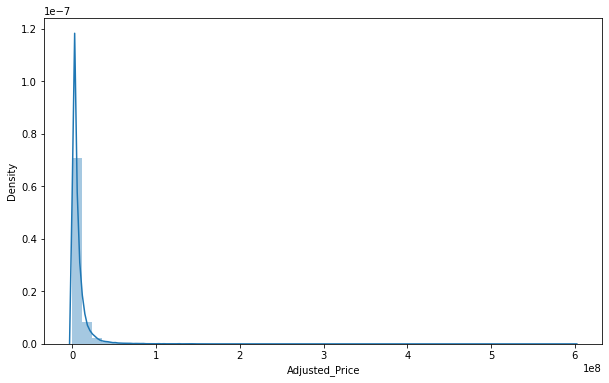

In [117]:
plt.figure(figsize=(10,6))
sns.distplot(data_inflated["Adjusted_Price"])
plt.show()

- We will perform log transformation for the target and inverse transformation for the predictions

C:\Users\Mourad\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


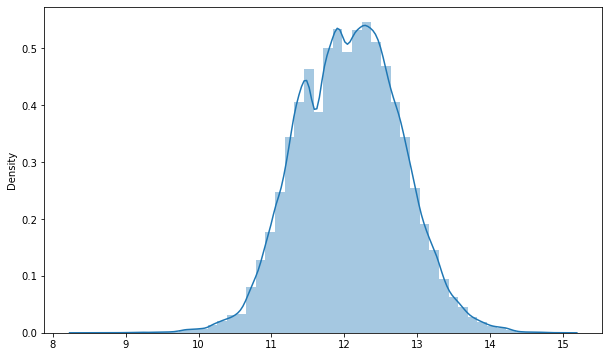

In [118]:
plt.figure(figsize=(10,6))
sns.distplot(stats.boxcox(data_inflated["Adjusted_Price"])[0])
plt.show()

### Linear Regression Model

In [119]:
features = data_inflated.drop(columns=["prices", "core_inflation", "CPI", "years" , "Adjusted_Price", "size_range"])
features["Price_per_m"] = features["Price_per_m"] / 10000
features

,locations,Price_per_m,rooms,bathrooms,finishes,views,floors,payments,property_age,decade
0,2,7.0740,1,1,1,2,0,1,-5.0,2
1,2,6.1571,1,1,1,2,0,1,-4.0,2
2,2,4.9500,1,1,2,1,0,1,-3.0,2
3,2,13.8076,1,1,2,1,0,1,-2.0,2
4,1,9.5454,1,1,5,2,0,1,-1.0,1
...,...,...,...,...,...,...,...,...,...,...
259813,3,6.1360,4,5,5,1,10,2,-3.0,2
259814,2,3.6956,4,5,4,2,10,0,8.0,0
259815,3,5.1515,4,5,4,5,10,0,4.0,0
259816,2,1.8000,5,5,4,3,10,0,3.0,1


In [120]:
target = data_inflated["Adjusted_Price"]
target = target / 10000000
target, lambda_fitted = stats.boxcox(target)
target

array([ 0.40216359, -0.91446831, -1.05687673, ...,  1.04251004,
        0.39817853,  1.73298419])

In [121]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42, shuffle= True)

In [122]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [123]:
scaler = RobustScaler()
X_train[["Price_per_m"]] = scaler.fit_transform(X_train[["Price_per_m"]])
X_test[["Price_per_m"]] = scaler.transform(X_test[["Price_per_m"]])

scaler = RobustScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)


C:\Users\Mourad\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\Mourad\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [124]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the OLS model
model = sm.OLS(y_train_scaled, X_train).fit()

# Print out the statistics
print(model.summary())

C:\Users\Mourad\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                 2.623e+04
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        01:32:43   Log-Likelihood:            -1.0607e+05
No. Observations:              174078   AIC:                         2.122e+05
Df Residuals:                  174067   BIC:                         2.123e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.8888      0.007   -125.123   

In [125]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test_scaled, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Optionally, calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 0.1969525957496006
Root Mean Squared Error (RMSE): 0.44379341562217955


In [126]:
r2_score(y_test_scaled, y_pred)

0.6012655965123278

##### Multicollinearity

In [127]:
vif_data = pd.DataFrame()
vif_data["Variable"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(1, X_train.shape[1])]

print(vif_data)

       Variable       VIF
0     locations  1.102534
1   Price_per_m  1.529661
2         rooms  1.428944
3     bathrooms  1.586779
4      finishes  1.211708
5         views  1.132607
6        floors  1.135568
7      payments  1.873359
8  property_age  1.667108
9        decade  1.319667


- No Multicollinearity

##### Checking Homoscedasticity

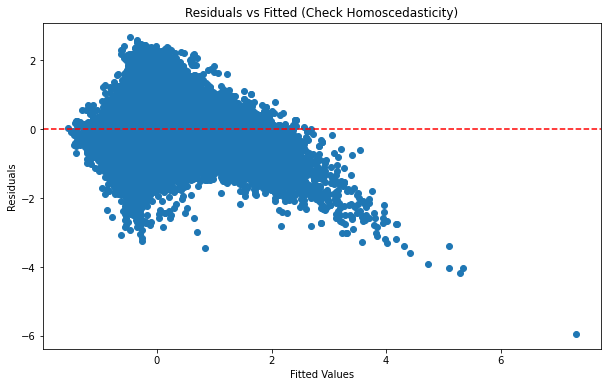

In [128]:
residuals = model.resid
fitted = model.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(fitted, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Check Homoscedasticity)")
plt.show()

In [129]:
bp_test = het_breuschpagan(residuals, X_train)
print(f"Breusch-Pagan Test p-value: {bp_test[1]}")
print(bp_test[1] < .05)

Breusch-Pagan Test p-value: 0.0
True


- This is heteroscedasticity Problem we will Use CART Models